In [214]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as stats
import missingno as msno
from sklearn.impute import KNNImputer
from plotnine import ggplot, aes, geom_bar, geom_text, labs, theme_minimal
from datetime import datetime
from matplotlib_venn import venn2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import warnings
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [94]:
# Read Train data
x_train_IP = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
x_train_OP =pd.read_csv('Train_Outpatientdata-1542865627584.csv')
x_train_BEN=pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
y_train    =pd.read_csv('Train-1542865627584.csv')

In [95]:
# Read Test data
x_test_IP = pd.read_csv('Test_Inpatientdata-1542969243754.csv')
x_test_OP =pd.read_csv('Test_Outpatientdata-1542969243754.csv')
x_test_BEN=pd.read_csv('Test_Beneficiarydata-1542969243754.csv')
y_test    =pd.read_csv('Test-1542969243754.csv')

In [96]:
print(x_train_IP.shape)
print(x_train_OP.shape)
print(x_train_BEN.shape)
print(y_train.shape)


(40474, 30)
(517737, 27)
(138556, 25)
(5410, 2)


In [97]:
print(y_test)

      Provider
0     PRV51002
1     PRV51006
2     PRV51009
3     PRV51010
4     PRV51018
...        ...
1348  PRV57713
1349  PRV57726
1350  PRV57745
1351  PRV57749
1352  PRV57750

[1353 rows x 1 columns]


In [98]:
# Ensure the columns are in datetime format
x_train_IP['DischargeDt'] = pd.to_datetime(x_train_IP['DischargeDt'], errors='coerce')
x_train_IP['AdmissionDt'] = pd.to_datetime(x_train_IP['AdmissionDt'], errors='coerce')

# Calculate hospital stay duration in days and round if necessary
x_train_IP['Hospital_Stay'] = (x_train_IP['DischargeDt'] - x_train_IP['AdmissionDt']).dt.days

# Handle cases where duration is negative or missing
x_train_IP['Hospital_Stay'] = x_train_IP['Hospital_Stay'].apply(lambda x: x if x >= 0 else None)

# Display the resulting DataFrame
print(x_train_IP[['AdmissionDt', 'DischargeDt', 'Hospital_Stay']].head())

  AdmissionDt DischargeDt  Hospital_Stay
0  2009-04-12  2009-04-18              6
1  2009-08-31  2009-09-02              2
2  2009-09-17  2009-09-20              3
3  2009-02-14  2009-02-22              8
4  2009-08-13  2009-08-30             17


In [99]:
# Get column names for X_train data
Inpatient_x_train_columns= set(x_train_IP.columns)
Outpatient_x_tain_columns=set(x_train_OP.columns)

In [100]:
# Find common columns
Common_columns= Inpatient_x_train_columns.intersection(Outpatient_x_tain_columns)
print("Common Columns:",Common_columns)

Common Columns: {'ClmDiagnosisCode_10', 'ClaimEndDt', 'ClmProcedureCode_6', 'ClmDiagnosisCode_4', 'ClmProcedureCode_1', 'OperatingPhysician', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_1', 'ClaimStartDt', 'ClmDiagnosisCode_2', 'ClaimID', 'BeneID', 'ClmProcedureCode_4', 'ClmDiagnosisCode_5', 'Provider', 'DeductibleAmtPaid', 'InscClaimAmtReimbursed', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_8', 'ClmAdmitDiagnosisCode', 'ClmProcedureCode_3', 'OtherPhysician', 'ClmProcedureCode_2', 'ClmProcedureCode_5', 'AttendingPhysician'}


In [101]:
# Find unique Columns to Inpatient_columns
Inpatient_unique_columns=Inpatient_x_train_columns-Outpatient_x_tain_columns
print ("Inpatient unique columns:", Inpatient_unique_columns)

Inpatient unique columns: {'Hospital_Stay', 'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode'}


In [102]:
print(x_train_IP.columns)
print(x_train_OP.columns)
print(x_train_BEN.columns)
print(y_train.columns)

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Hospital_Stay'],
      dtype='object')
Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',

In [103]:
x_train_IP.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Hospital_Stay
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,2
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,8
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,17


In [104]:
x_train_OP.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [105]:
y_train.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


                count  percentage
PotentialFraud                   
No               4904    90.64695
Yes               506     9.35305


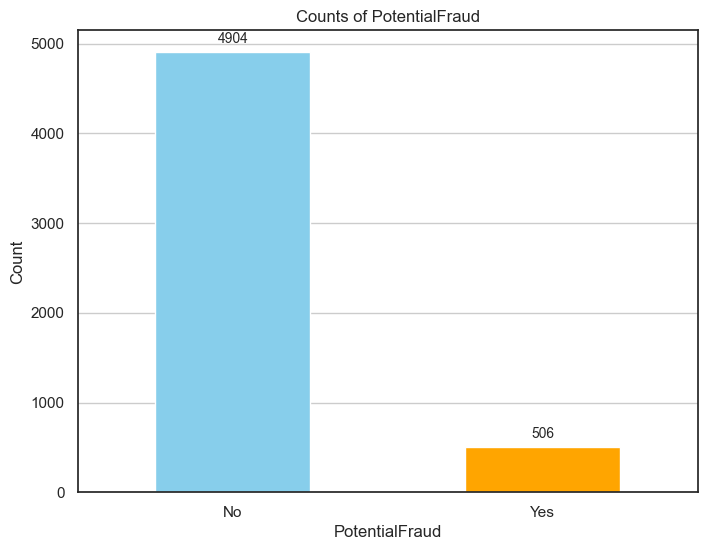

In [106]:
# Compute the count and the percentage distribution of providers with or without fraud.
column_name='PotentialFraud'
if column_name in y_train:
    # Calculate value counts and percentages
    value_counts = y_train[column_name].value_counts()
    total_counts = value_counts.sum()
    percentages = (value_counts / total_counts) * 100

    # Create a DataFrame with counts and percentages
    result = pd.DataFrame({
        'count': value_counts,
        'percentage': percentages
    })

    print(result)

   # Bar plot
    ax = value_counts.plot(kind='bar', color=['skyblue', 'orange'], figsize=(8, 6))
    plt.title(f"Counts of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.grid(axis='y')

    # Add labels
    for i, v in enumerate(value_counts):
        ax.text(i, v + 100, str(v), ha='center', fontsize=10)

    plt.show()

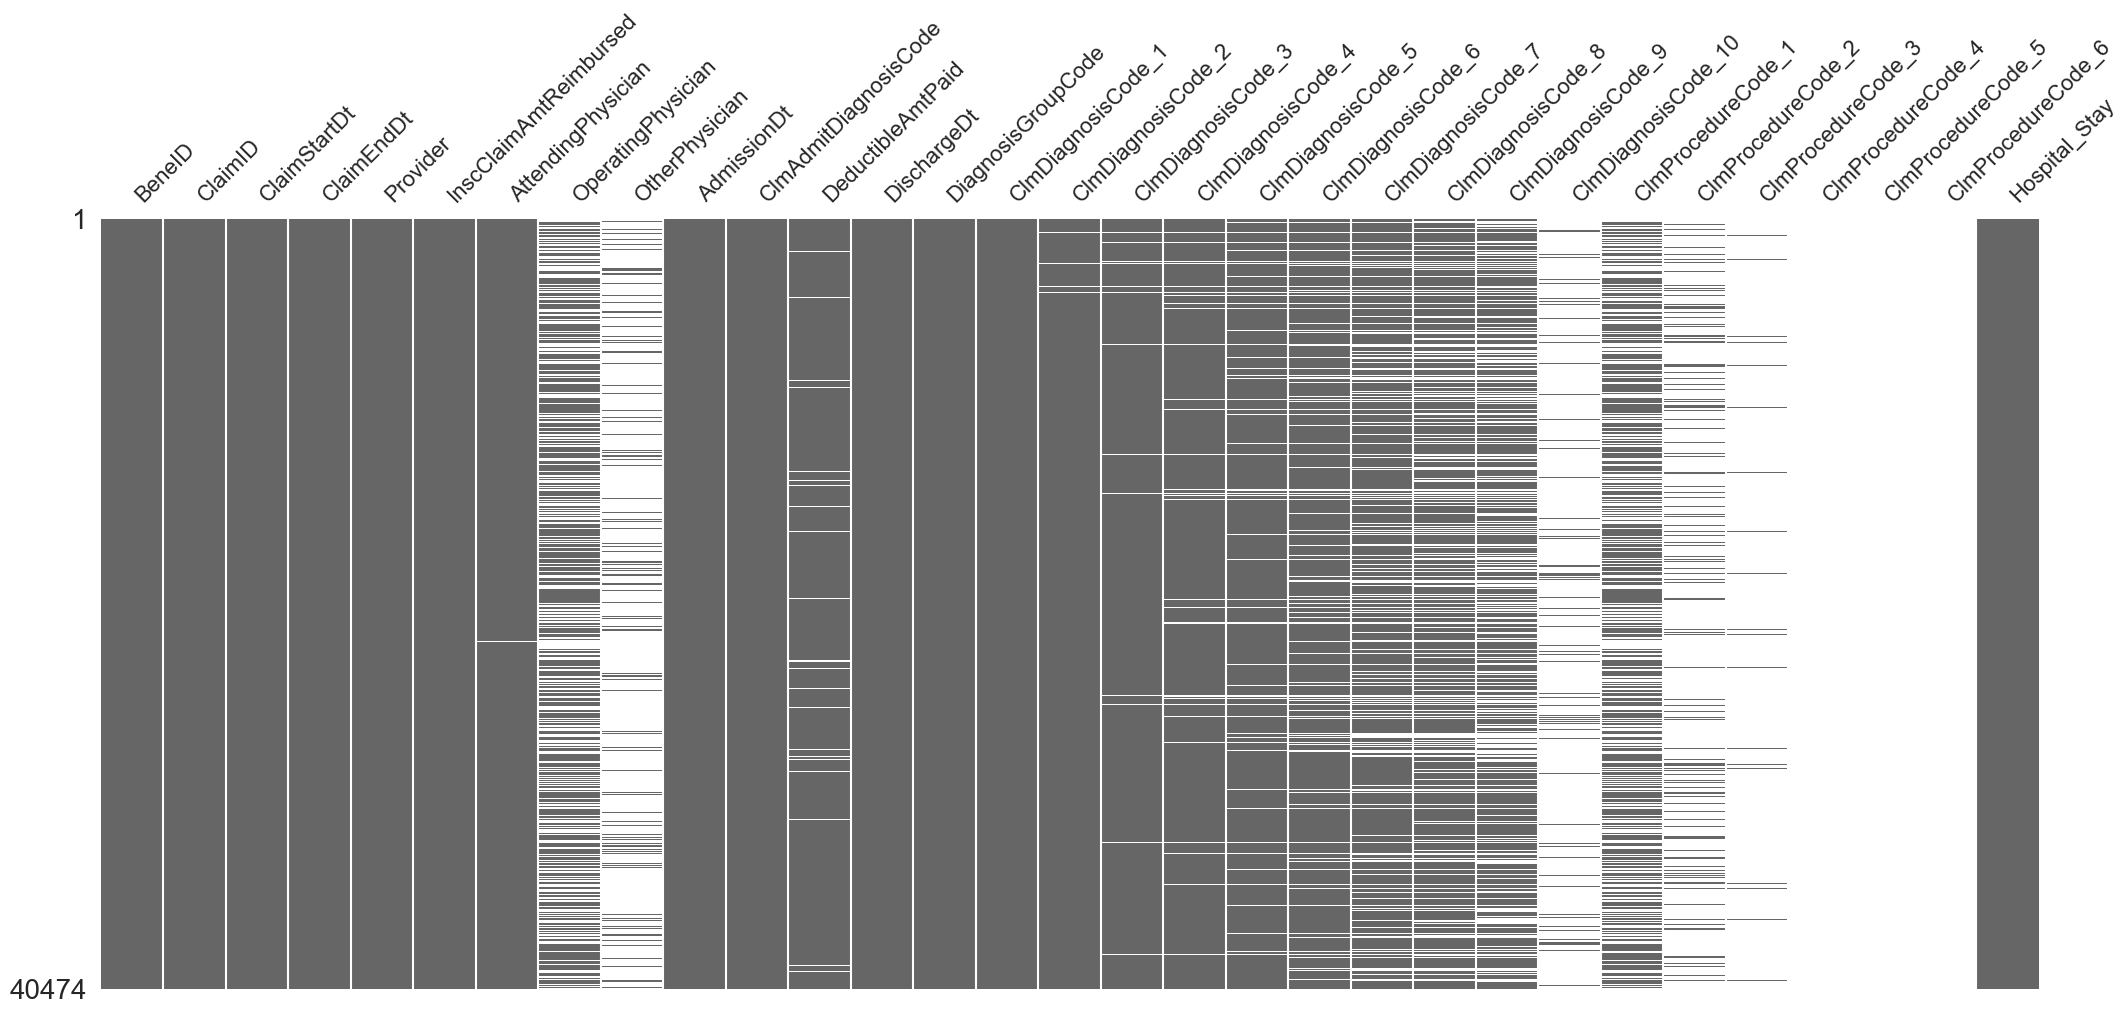

In [107]:
#Looking at missing values for  Train Inpatient data
msno.matrix(x_train_IP, sparkline=False, color=(0.4,0.4, 0.4));

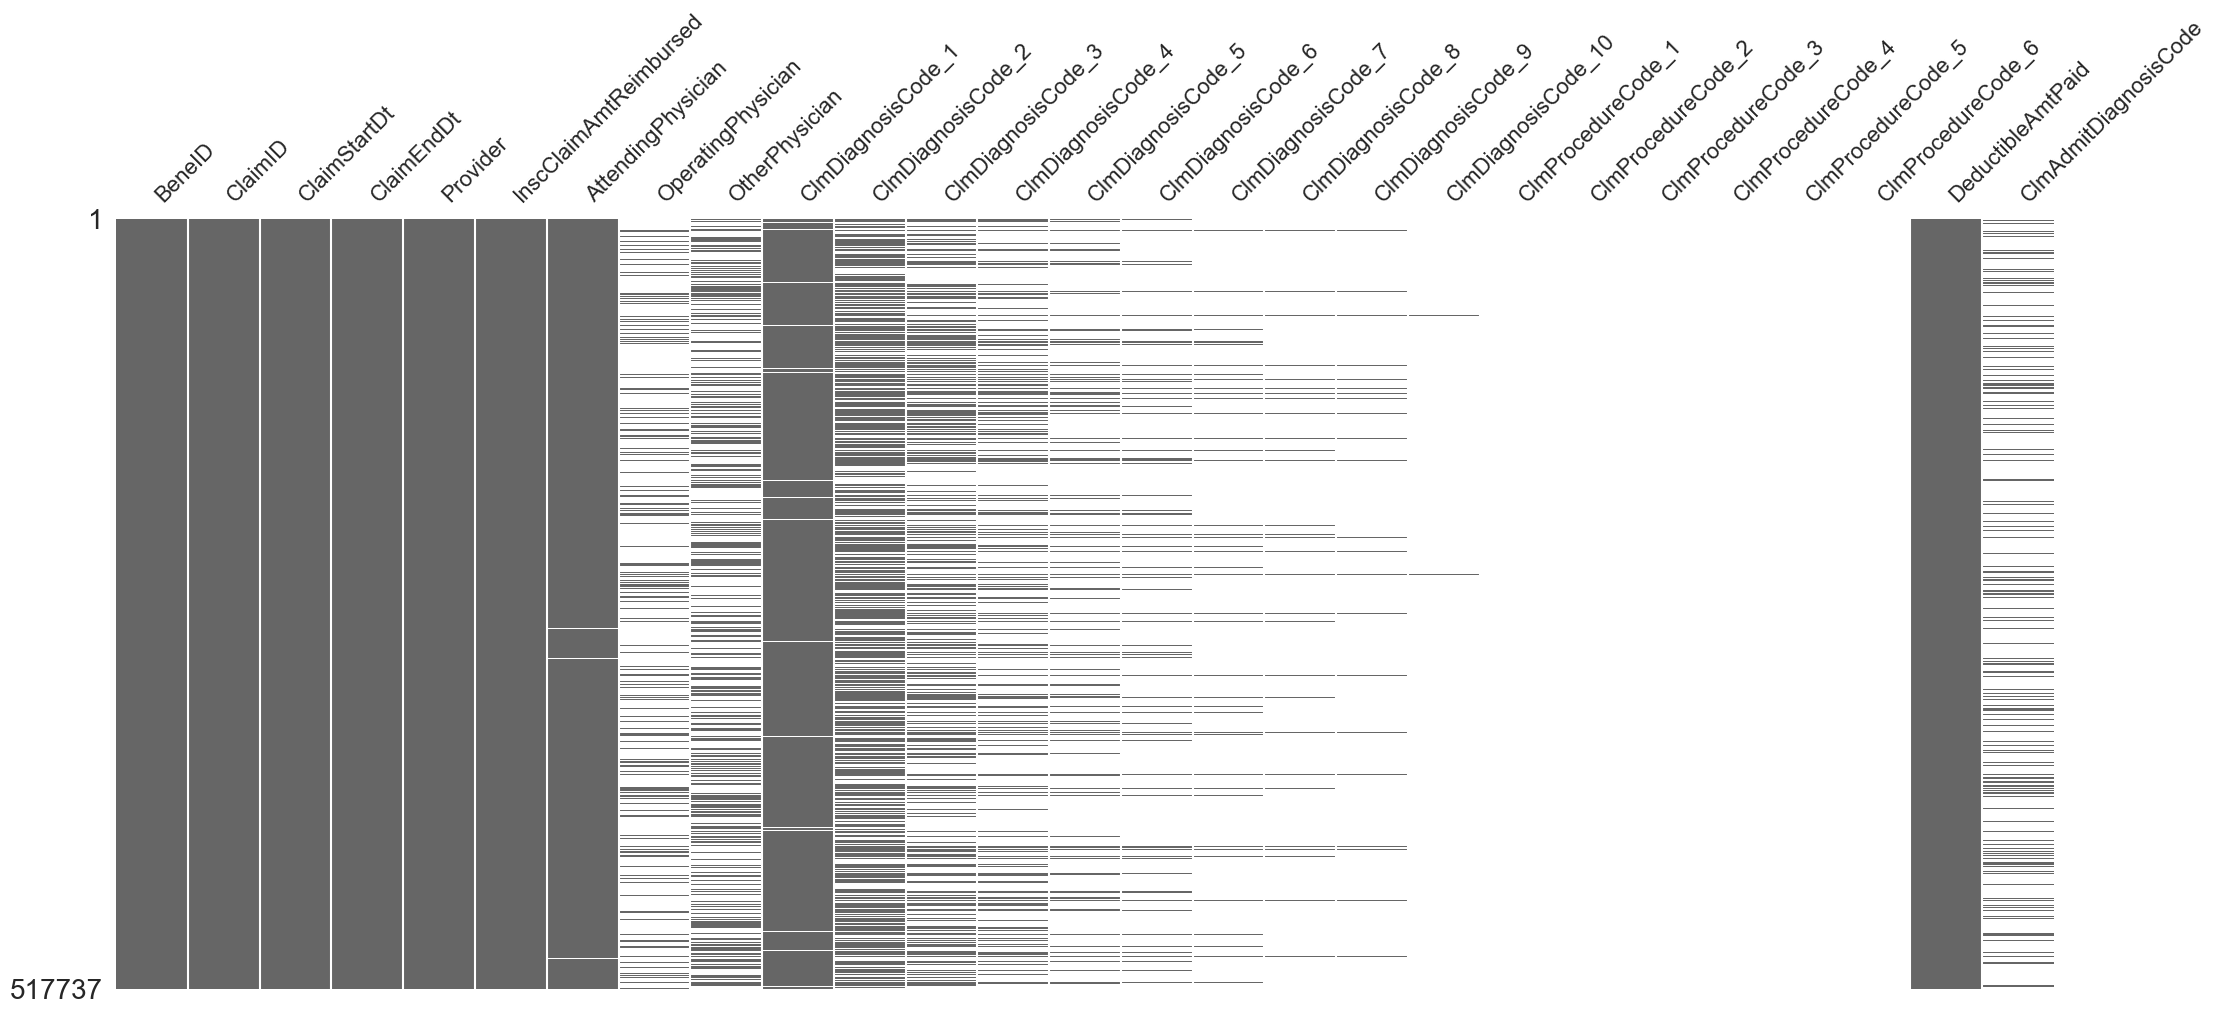

In [108]:
#Looking at missing values for Train Outpatient data
msno.matrix(x_train_OP, sparkline=False, color=(0.4,0.4, 0.4));

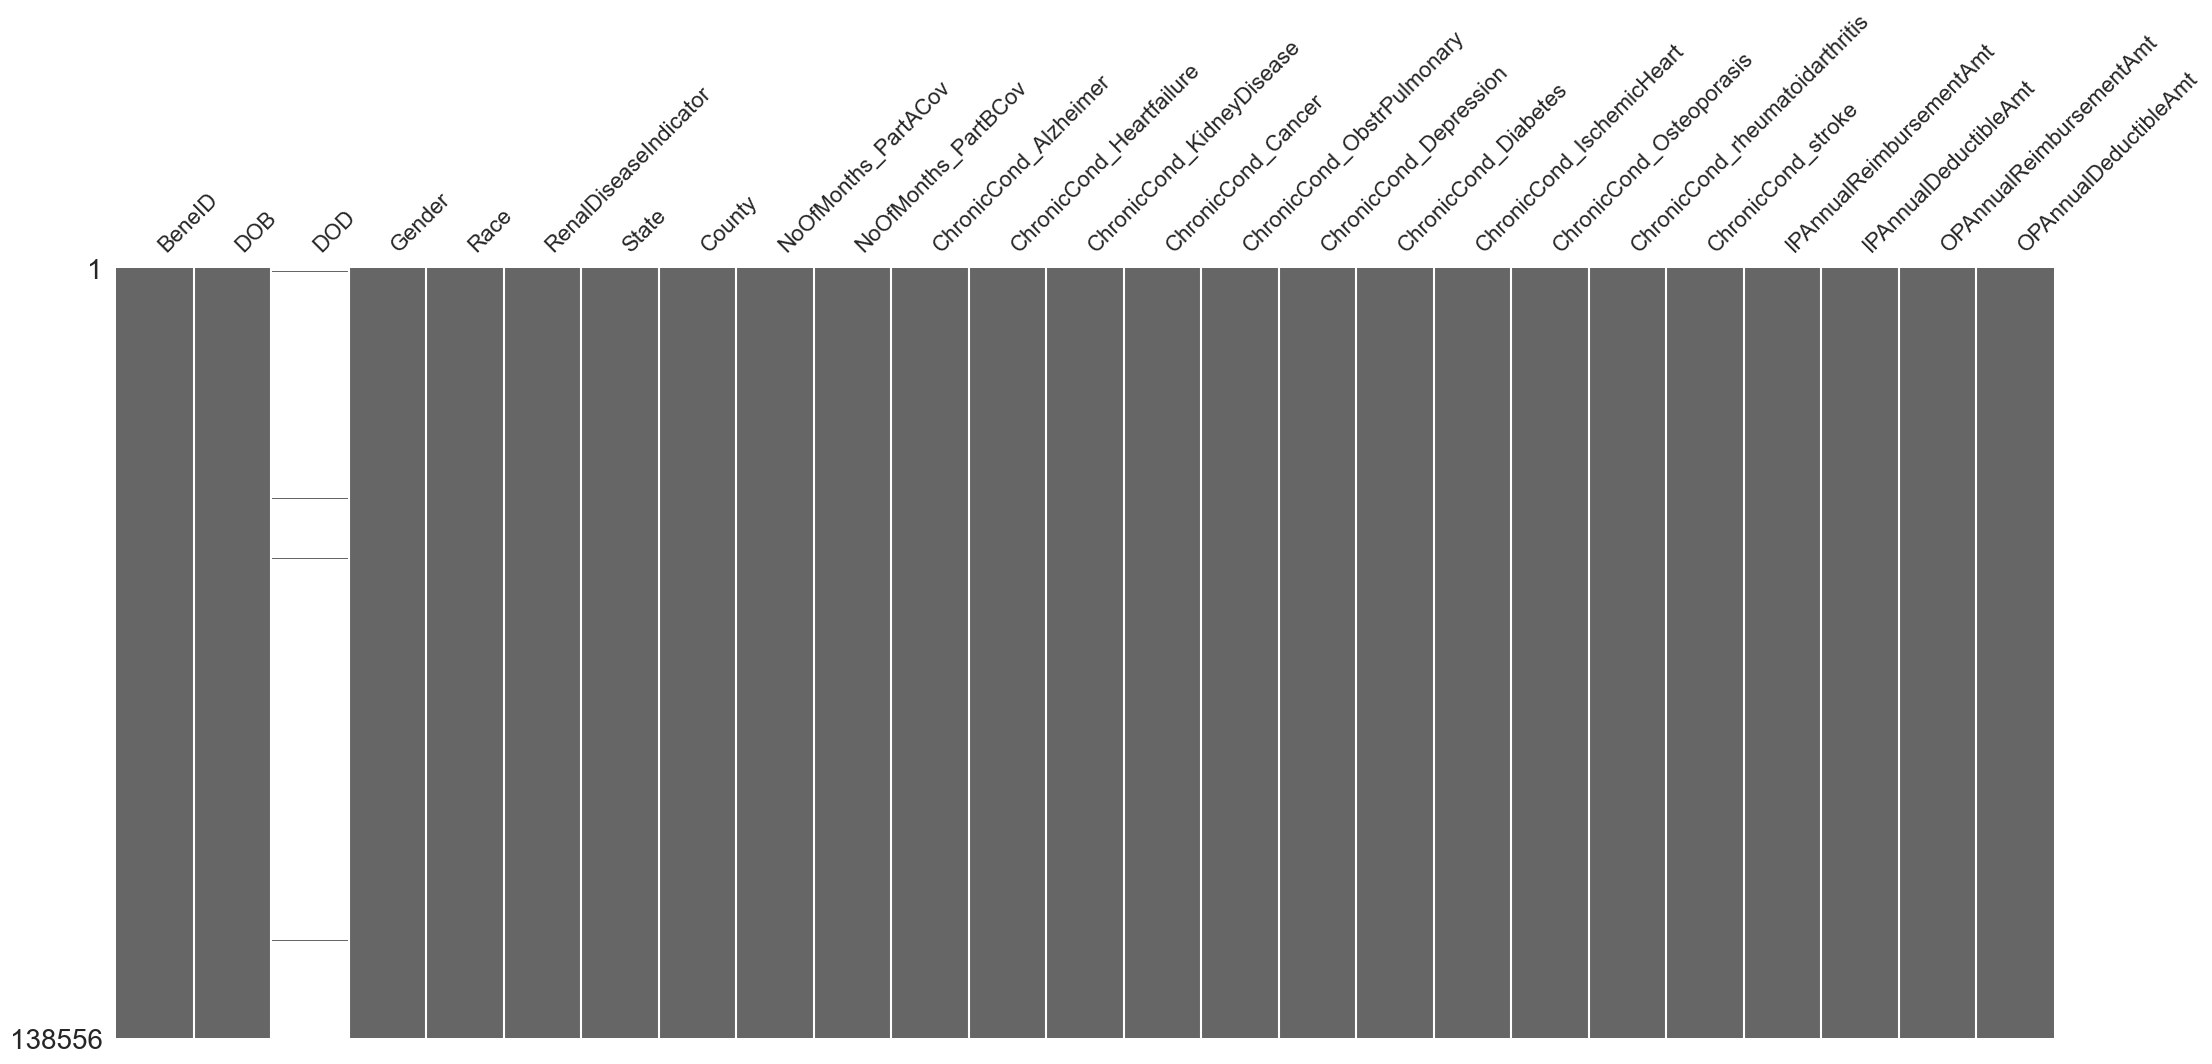

In [109]:
#Looking at missing values for train Beneficiary  data
msno.matrix(x_train_BEN, sparkline=False, color=(0.4,0.4, 0.4));

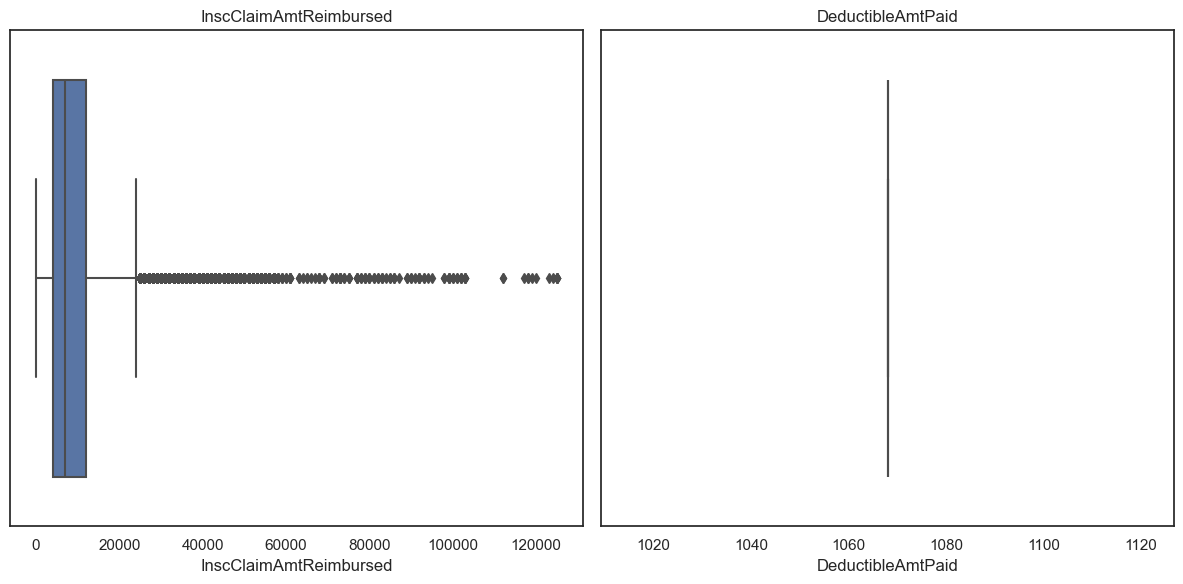

In [110]:
# Looking for outliers for x_train Inpatient data
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First Boxplot: InscClaimAmtReimbursed
sns.boxplot(x=x_train_IP['InscClaimAmtReimbursed'], ax=axes[0])
axes[0].set_title('InscClaimAmtReimbursed')

# Second Boxplot: DeductibleAmtPaid
sns.boxplot(x=x_train_IP['DeductibleAmtPaid'], ax=axes[1])
axes[1].set_title('DeductibleAmtPaid')

plt.tight_layout()
plt.show()

In [111]:
#Imputation for x_train Inpatient data
# Function to impute numerical features with median and categorical with 'Unknown'
def impute_missing_values(x_train_IP):
    # Impute numerical columns with median
    numerical_cols = x_train_IP.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_cols:
        x_train_IP[col] = x_train_IP[col].fillna(x_train_IP[col].median())
    
    # Impute categorical columns with 'Unknown'
    categorical_cols = x_train_IP.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        x_train_IP[col] = x_train_IP[col].fillna('Unknown')
    
    # Impute datetime columns with a default date or NaT (Not a Time)
    datetime_cols = x_train_IP.select_dtypes(include=['datetime64']).columns
    for col in datetime_cols:
        x_train_IP[col] = x_train_IP[col].fillna(pd.NaT)  
    
    return x_train_IP

# Apply the imputation function
x_train_IP_imputed = impute_missing_values(x_train_IP)

In [112]:
#Imputation for x_train Outpatient data
# Function to impute numerical features with median and categorical with 'Unknown'
def impute_missing_values(x_train_OP):
    # Impute numerical columns with median
    numerical_cols = x_train_OP.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_cols:
        x_train_OP[col] = x_train_OP[col].fillna(x_train_OP[col].median())
    
    # Impute categorical columns with 'Unknown'
    categorical_cols = x_train_OP.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        x_train_OP[col] = x_train_OP[col].fillna('Unknown')
    
    return x_train_OP

# Apply the imputation function
x_train_OP_imputed = impute_missing_values(x_train_OP)

In [113]:
# create a new column 'claim_duration' from the difference between ClaimEndDt and ClaimStartDt in Inpatient data
# Create a DataFrame
x_train_IP_imputed = pd.DataFrame(x_train_IP_imputed)

# Convert columns to datetime
x_train_IP_imputed['ClaimStartDt'] = pd.to_datetime(x_train_IP_imputed['ClaimStartDt'])
x_train_IP_imputed['ClaimEndDt'] = pd.to_datetime(x_train_IP_imputed['ClaimEndDt'])

# Calculate claim duration in days and create a new column
x_train_IP_imputed['claim_duration'] = (x_train_IP_imputed['ClaimEndDt'] - x_train_IP_imputed['ClaimStartDt']).dt.days

In [114]:
# Calculate the average claim duration for Inpatient data
average_claim_duration = x_train_IP_imputed['claim_duration'].mean()

# Display the average claim duration
print(f"The average claim duration is {average_claim_duration:.2f} days.")

The average claim duration is 5.66 days.


In [115]:
x_train_IP_imputed['ClmProcedureCode_6'] = x_train_IP_imputed['ClmProcedureCode_6'].fillna('unknown')

In [116]:
x_train_OP_imputed[['ClmProcedureCode_5', 'ClmProcedureCode_6']] = x_train_OP_imputed[['ClmProcedureCode_5', 'ClmProcedureCode_6']].fillna('unknown')

In [117]:
x_train_BEN['DOD'] = x_train_BEN['DOD'].fillna('Not Deceased')

In [118]:
x_train_BEN['DOD'] = x_train_BEN['DOD'].fillna('Not Deceased')

In [119]:
#Number of medical doctors in the train Inpatient dataset
# Combine the three columns into one series and find unique doctors
physician_columns = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
unique_doctors = pd.concat([x_train_IP_imputed[col] for col in physician_columns]).nunique()

# Print the result
print(f"There are {unique_doctors} unique doctors in the inpatient dataset.")

There are 18257 unique doctors in the inpatient dataset.


In [120]:
#Number of medical doctors in the train Outpatient dataset
# Combine the three columns into one series and find unique doctors
physician_columns = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
unique_doctors = pd.concat([x_train_OP_imputed[col] for col in physician_columns]).nunique()

# Print the result
print(f"There are {unique_doctors} unique doctors in the Outpatient dataset.")

There are 89771 unique doctors in the Outpatient dataset.


In [121]:
# Do those inpatient patients show worse health conditions (in terms of chronic diseases) than typical outpatient patients,
# List all chronics
chronic_conds = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
         'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
         'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
         'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

# Ensure all are ints and absolute vals
for cond in chronic_conds:
    x_train_BEN[cond] = list(map(lambda x: np.abs(int(x)), x_train_BEN[cond]))
    
# Generate Number of Chronic Conds
x_train_BEN.loc[:,'Num_ChronicConds'] = x_train_BEN[chronic_conds].sum(axis=1)

In [122]:
#Distinct Patients in the Inpatient Dataset
# For Inpatient dataset
distinct_inpatient_patients = x_train_IP_imputed['BeneID'].nunique()
print(f"Number of distinct inpatient patients: {distinct_inpatient_patients}")

Number of distinct inpatient patients: 31289


In [123]:
#Distinct Patients in the Outpatient Dataset
# For Outpatient dataset
distinct_outpatient_patients = x_train_OP_imputed['BeneID'].nunique()
print(f"Number of distinct outpatient patients: {distinct_outpatient_patients}")

Number of distinct outpatient patients: 133980


In [124]:
#The total number of distinct patients across both inpatient and outpatient datasets
# Combine inpatient and outpatient datasets (assuming they are in separate DataFrames)
combined_beneids = pd.concat([x_train_IP_imputed['BeneID'], x_train_OP_imputed['BeneID']])

# Count the number of unique BeneIDs
distinct_patients_combined = combined_beneids.nunique()
print(f"Total number of distinct patients across inpatient and outpatient datasets: {distinct_patients_combined}")

Total number of distinct patients across inpatient and outpatient datasets: 138556


In [125]:
# For Inpatient dataset
#Do doctors serve for different providers?
# Check if doctors serve different providers

# For attending physicians
physician_provider_count = x_train_IP_imputed.groupby('AttendingPhysician')['Provider'].nunique()

# Check how many doctors serve multiple providers
doctors_multiple_providers = physician_provider_count[physician_provider_count > 1]
print(f"Number of AttendingPhysician serving multiple providers: {len(doctors_multiple_providers)}")

# For OperatingPhysician
operating_physician_provider_count = x_train_IP_imputed.groupby('OperatingPhysician')['Provider'].nunique()
doctors_operating_multiple_providers = operating_physician_provider_count[operating_physician_provider_count > 1]
print(f"Number of OperatingPhysician serving multiple providers: {len(doctors_operating_multiple_providers)}")

# For OtherPhysician
other_physician_provider_count = x_train_IP_imputed.groupby('OtherPhysician')['Provider'].nunique()
doctors_other_multiple_providers = other_physician_provider_count[other_physician_provider_count > 1]
print(f"Number of other doctors serving multiple providers: {len(doctors_other_multiple_providers)}")

Number of AttendingPhysician serving multiple providers: 196
Number of OperatingPhysician serving multiple providers: 100
Number of other doctors serving multiple providers: 20


In [126]:
# For Outpatient dataset
#Do doctors serve for different providers?
# Check if doctors serve different providers

# For attending physicians
physician_provider_count = x_train_OP_imputed.groupby('AttendingPhysician')['Provider'].nunique()

# Check how many doctors serve multiple providers
doctors_multiple_providers = physician_provider_count[physician_provider_count > 1]
print(f"Number of doctors serving multiple providers: {len(doctors_multiple_providers)}")
# For OperatingPhysician
operating_physician_provider_count = x_train_OP_imputed.groupby('OperatingPhysician')['Provider'].nunique()
doctors_operating_multiple_providers = operating_physician_provider_count[operating_physician_provider_count > 1]
print(f"Number of OperatingPhysician serving multiple providers: {len(doctors_operating_multiple_providers)}")

# For OtherPhysician
other_physician_provider_count = x_train_OP_imputed.groupby('OtherPhysician')['Provider'].nunique()
doctors_other_multiple_providers = other_physician_provider_count[other_physician_provider_count > 1]
print(f"Number of other doctors serving multiple providers: {len(doctors_other_multiple_providers)}")

Number of doctors serving multiple providers: 4587
Number of OperatingPhysician serving multiple providers: 943
Number of other doctors serving multiple providers: 1909


In [127]:
# For Inpatient dataset
# Let's assume 'Provider' represents hospitals, and 'AttendingPhysician', 'OperatingPhysician', and 'OtherPhysician' represent doctors.

# For Attending Physicians, count the number of unique hospitals they are associated with
doctor_hospital_counts_attending = x_train_IP_imputed.groupby('AttendingPhysician')['Provider'].nunique()

# For Operating Physicians, count the number of unique hospitals they are associated with
doctor_hospital_counts_operating = x_train_IP_imputed.groupby('OperatingPhysician')['Provider'].nunique()

# For Other Physicians, count the number of unique hospitals they are associated with
doctor_hospital_counts_other = x_train_IP_imputed.groupby('OtherPhysician')['Provider'].nunique()

# Combine the results into one dataframe to view the distribution
hospital_counts_combined = pd.concat([doctor_hospital_counts_attending, doctor_hospital_counts_operating, doctor_hospital_counts_other], axis=1)
hospital_counts_combined.columns = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

# Now check the first few rows
print(hospital_counts_combined.head())

           AttendingPhysician  OperatingPhysician  OtherPhysician
PHY311002                 1.0                 NaN             NaN
PHY311023                 1.0                 NaN             NaN
PHY311028                 1.0                 NaN             NaN
PHY311035                 1.0                 NaN             NaN
PHY311056                 1.0                 NaN             NaN


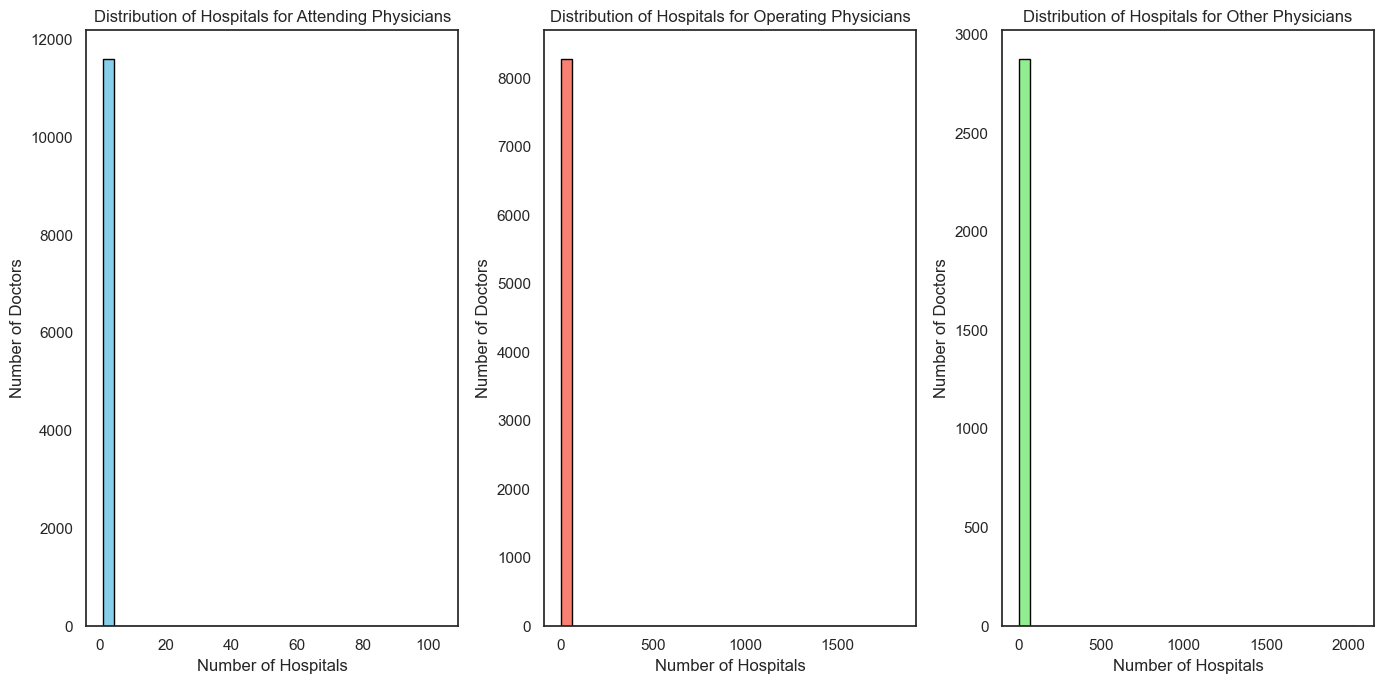

In [128]:
# Plotting the distribution of hospital counts for each physician type
plt.figure(figsize=(14, 7))

# Plot for Attending Physicians
plt.subplot(1, 3, 1)
doctor_hospital_counts_attending.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Hospitals for Attending Physicians')
plt.xlabel('Number of Hospitals')
plt.ylabel('Number of Doctors')

# Plot for Operating Physicians
plt.subplot(1, 3, 2)
doctor_hospital_counts_operating.plot(kind='hist', bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Hospitals for Operating Physicians')
plt.xlabel('Number of Hospitals')
plt.ylabel('Number of Doctors')

# Plot for Other Physicians
plt.subplot(1, 3, 3)
doctor_hospital_counts_other.plot(kind='hist', bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Hospitals for Other Physicians')
plt.xlabel('Number of Hospitals')
plt.ylabel('Number of Doctors')

# Show the plots
plt.tight_layout()
plt.show()

In [129]:
# Summary statistics for each physician type
print("Attending Physicians Summary:")
print(doctor_hospital_counts_attending.describe())

print("\nOperating Physicians Summary:")
print(doctor_hospital_counts_operating.describe())

print("\nOther Physicians Summary:")
print(doctor_hospital_counts_other.describe())

Attending Physicians Summary:
count    11605.000000
mean         1.026109
std          0.965230
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        104.000000
Name: Provider, dtype: float64

Operating Physicians Summary:
count    8288.000000
mean        1.233470
std        20.167464
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1837.000000
Name: Provider, dtype: float64

Other Physicians Summary:
count    2878.000000
mean        1.719944
std        38.250016
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      2053.000000
Name: Provider, dtype: float64


In [130]:
''' Is it possible to characterize those doctors who move around among different providers?
It is possible to characterize doctors who move around among different providers. 
To do so, you would need to identify physicians associated with multiple providers (hospitals) and 
analyze their patterns to understand their mobility. By examining the number of unique providers (hospitals) each doctor is associated with,
you can classify doctors who frequently work across various providers.'''
# For Inpatient dataset
# Count the number of unique providers each physician serves
doctor_hospital_counts = {
    'AttendingPhysician': x_train_IP_imputed.groupby('AttendingPhysician')['Provider'].nunique(),
    'OperatingPhysician': x_train_IP_imputed.groupby('OperatingPhysician')['Provider'].nunique(),
    'OtherPhysician': x_train_IP_imputed.groupby('OtherPhysician')['Provider'].nunique()
}

# Combine the counts into a single dataframe
doctor_hospital_counts_combined = pd.concat(doctor_hospital_counts, axis=1)
doctor_hospital_counts_combined.columns = ['Attending', 'Operating', 'Other']

# Find doctors who serve multiple providers
threshold = 1  # You can adjust this threshold to define what counts as "moving around"
moving_doctors = doctor_hospital_counts_combined[(doctor_hospital_counts_combined > threshold).any(axis=1)]

# Display the doctors who serve multiple providers
print(f"Number of doctors who serve multiple providers: {len(moving_doctors)}")

Number of doctors who serve multiple providers: 286


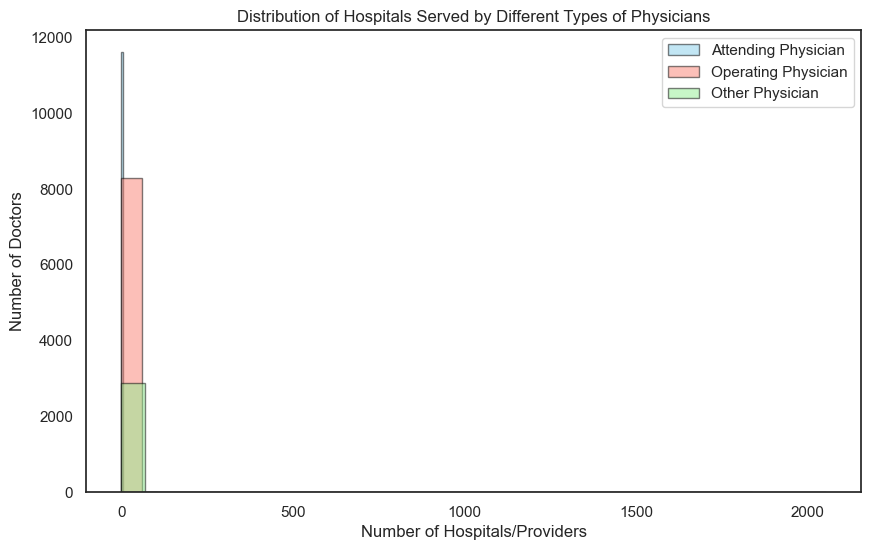

In [131]:
# Plot the number of providers each doctor serves
plt.figure(figsize=(10, 6))

# Create histograms for the count of providers each doctor serves
doctor_hospital_counts_combined['Attending'].plot(kind='hist', bins=30, alpha=0.5, label='Attending Physician', color='skyblue', edgecolor='black')
doctor_hospital_counts_combined['Operating'].plot(kind='hist', bins=30, alpha=0.5, label='Operating Physician', color='salmon', edgecolor='black')
doctor_hospital_counts_combined['Other'].plot(kind='hist', bins=30, alpha=0.5, label='Other Physician', color='lightgreen', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Hospitals Served by Different Types of Physicians')
plt.xlabel('Number of Hospitals/Providers')
plt.ylabel('Number of Doctors')
plt.legend()

# Show the plot
plt.show()

In [132]:
# Characterizing the "Movers
# Mobility index: Count of unique providers served by each doctor
doctor_hospital_counts_combined['MobilityIndex'] = doctor_hospital_counts_combined.max(axis=1)

# Doctors who serve more than a certain number of hospitals can be considered high-mobility doctors
high_mobility_doctors = doctor_hospital_counts_combined[doctor_hospital_counts_combined['MobilityIndex'] > 1]
print(f"Number of high mobility doctors: {len(high_mobility_doctors)}")

Number of high mobility doctors: 286


In [133]:
#Do the same providers provide both inpatient and outpatient services? Extract Unique Providers,
#Use set operations to find the intersection of ProviderIDs between the two datasets
# Extract unique ProviderIDs from inpatient and outpatient datasets
inpatient_providers = set(x_train_IP_imputed['Provider'].unique())
outpatient_providers = set(x_train_OP_imputed['Provider'].unique())
print(f"Number of unique inpatient providers: {len(inpatient_providers)}")
print(f"Number of unique outpatient providers: {len(outpatient_providers)}")

Number of unique inpatient providers: 2092
Number of unique outpatient providers: 5012


In [134]:
# Find the intersection of inpatient and outpatient providers
common_providers = inpatient_providers.intersection(outpatient_providers)

# Display count of common providers
print(f"Number of providers offering both inpatient and outpatient services: {len(common_providers)}")

Number of providers offering both inpatient and outpatient services: 1694


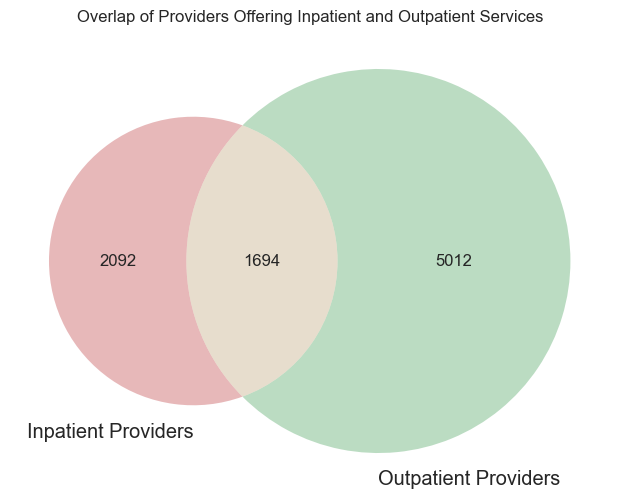

In [135]:
# Create a Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2(
    subsets=(len(inpatient_providers), len(outpatient_providers), len(common_providers)),
    set_labels=('Inpatient Providers', 'Outpatient Providers')
)

# Add title
plt.title('Overlap of Providers Offering Inpatient and Outpatient Services')
plt.show()

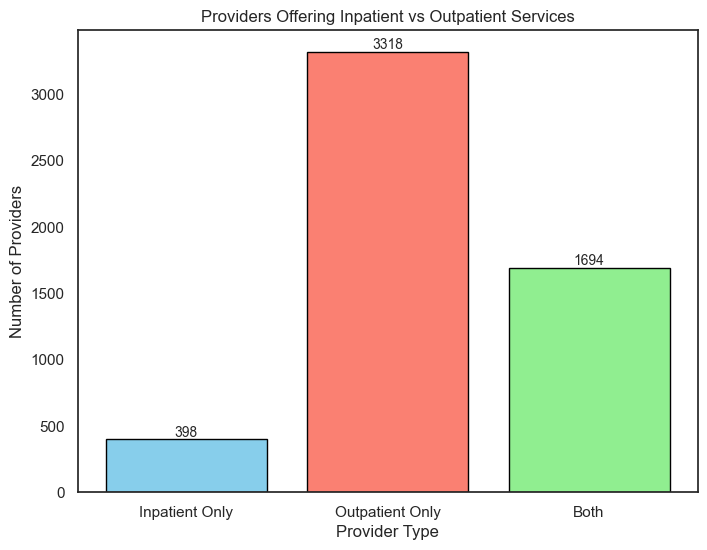

In [136]:
# Data for bar plot
categories = ['Inpatient Only', 'Outpatient Only', 'Both']
values = [
    len(inpatient_providers - common_providers),
    len(outpatient_providers - common_providers),
    len(common_providers)
]

# Plot the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color=['skyblue', 'salmon', 'lightgreen'], edgecolor='black')

# Add titles and labels
plt.title('Providers Offering Inpatient vs Outpatient Services')
plt.xlabel('Provider Type')
plt.ylabel('Number of Providers')

# Add bar lengths (values) on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,  # X position (center of the bar)
        height,                               # Y position (height of the bar)
        f'{height}',                          # Text to display
        ha='center',                          # Horizontal alignment
        va='bottom',                          # Vertical alignment
        fontsize=10                           # Font size
    )

# Show the plot
plt.show()

In [137]:
#Summary statistics
# Calculate percentages
total_providers = len(inpatient_providers.union(outpatient_providers))
percentage_both = (len(common_providers) / total_providers) * 100
percentage_inpatient_only = (len(inpatient_providers - common_providers) / total_providers) * 100
percentage_outpatient_only = (len(outpatient_providers - common_providers) / total_providers) * 100

print(f"Percentage of providers offering both services: {percentage_both:.2f}%")
print(f"Percentage of inpatient-only providers: {percentage_inpatient_only:.2f}%")
print(f"Percentage of outpatient-only providers: {percentage_outpatient_only:.2f}%")

Percentage of providers offering both services: 31.31%
Percentage of inpatient-only providers: 7.36%
Percentage of outpatient-only providers: 61.33%


In [138]:
# Do Some of the same patients receive both inpatient and outpatient services? analyze the BeneIDs (patient identifiers) overlap between 
#the inpatient and outpatient datasets. If there is an intersection of BeneIDs, then those patients received both types of services
# Extract unique BeneIDs from inpatient and outpatient datasets
inpatient_patients = set(x_train_IP_imputed['BeneID'].unique())
outpatient_patients = set(x_train_OP_imputed['BeneID'].unique())

# Display counts
print(f"Number of unique inpatient patients: {len(inpatient_patients)}")
print(f"Number of unique outpatient patients: {len(outpatient_patients)}")

Number of unique inpatient patients: 31289
Number of unique outpatient patients: 133980


In [139]:
# Find the intersection of inpatient and outpatient patients
common_patients = inpatient_patients.intersection(outpatient_patients)

# Display the count of common patients
print(f"Number of patients receiving both inpatient and outpatient services: {len(common_patients)}")

Number of patients receiving both inpatient and outpatient services: 26713


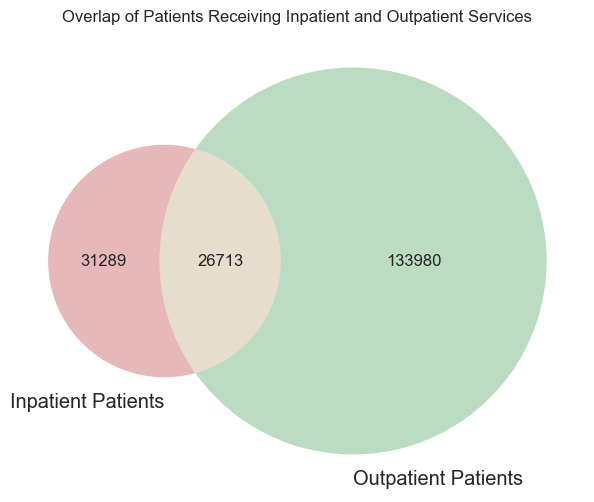

In [140]:
# Create a Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2(
    subsets=(len(inpatient_patients), len(outpatient_patients), len(common_patients)),
    set_labels=('Inpatient Patients', 'Outpatient Patients')
)

# Add title
plt.title('Overlap of Patients Receiving Inpatient and Outpatient Services')
plt.show()

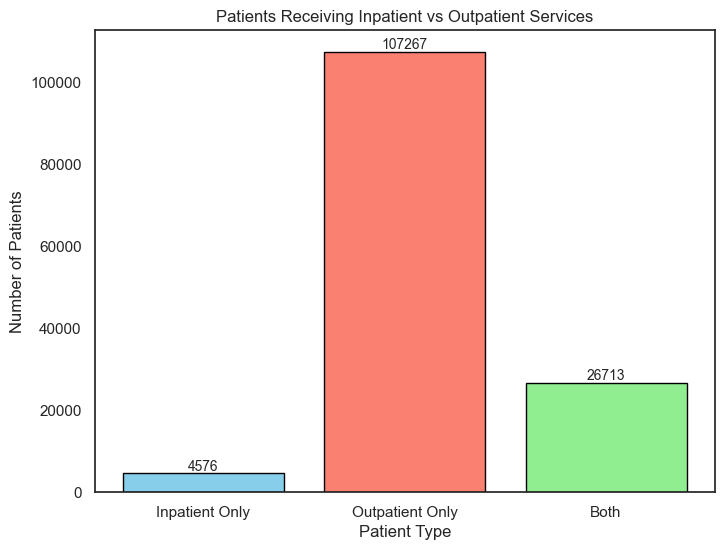

In [141]:
# Data for bar plot
categories = ['Inpatient Only', 'Outpatient Only', 'Both']
values = [
    len(inpatient_patients - common_patients),
    len(outpatient_patients - common_patients),
    len(common_patients)
]

# Plot the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color=['skyblue', 'salmon', 'lightgreen'], edgecolor='black')

# Add titles and labels
plt.title('Patients Receiving Inpatient vs Outpatient Services')
plt.xlabel('Patient Type')
plt.ylabel('Number of Patients')

# Add bar lengths on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

In [142]:
# Calculate percentages
total_patients = len(inpatient_patients.union(outpatient_patients))
percentage_both = (len(common_patients) / total_patients) * 100
percentage_inpatient_only = (len(inpatient_patients - common_patients) / total_patients) * 100
percentage_outpatient_only = (len(outpatient_patients - common_patients) / total_patients) * 100

print(f"Percentage of patients receiving both services: {percentage_both:.2f}%")
print(f"Percentage of inpatient-only patients: {percentage_inpatient_only:.2f}%")
print(f"Percentage of outpatient-only patients: {percentage_outpatient_only:.2f}%")

Percentage of patients receiving both services: 19.28%
Percentage of inpatient-only patients: 3.30%
Percentage of outpatient-only patients: 77.42%


In [143]:
# calculates the number of common elements between two columns
len([x for x in x_train_IP.loc[:, 'BeneID'] if x in x_train_OP.loc[:, 'BeneID']])

0

In [144]:
x_train_IP.loc[:, 'IsIP'] = 1
x_train_OP.loc[:, 'IsOP'] = 1
All_patient= pd.concat([x_train_IP, x_train_OP], ignore_index=True)

In [145]:
All_patient.shape

(558211, 33)

In [146]:
All_patient.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Hospital_Stay,IsIP,IsOP
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,Unknown,Unknown,2009-04-12,...,Unknown,5369.0,4019.0,4019.0,4019.0,4139.0,NaN,6.0,1.0,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,Unknown,2009-08-31,...,Unknown,7092.0,4019.0,4019.0,4019.0,4139.0,NaN,2.0,1.0,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,Unknown,PHY324689,2009-09-17,...,Unknown,5369.0,4019.0,4019.0,4019.0,4139.0,NaN,3.0,1.0,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,Unknown,331.0,4019.0,4019.0,4019.0,4139.0,NaN,8.0,1.0,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,Unknown,2009-08-13,...,Unknown,3893.0,4019.0,4019.0,4019.0,4139.0,NaN,17.0,1.0,NaN


In [147]:
All_patient_IOB = pd.merge( All_patient,x_train_BEN,how='left', on='BeneID').drop_duplicates()

In [148]:
All_patient_IOB.shape

(558211, 58)

In [149]:
# Convert date columns with explicit format handling
# Define a date format string 
date_format = "%Y-%m-%d"

# Convert date columns with a specified format
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']
for col in date_cols:
    if col in All_patient_IOB.columns:
        All_patient_IOB[col] = pd.to_datetime(All_patient_IOB[col],format=date_format, errors='coerce')

# Convert Provider to string
All_patient_IOB['Provider'] = All_patient_IOB['Provider'].astype(str)

# Convert all categorical columns to strings to avoid mode sorting errors
cat_cols = All_patient_IOB.select_dtypes(include=['object']).columns
All_patient_IOB[cat_cols] = All_patient_IOB[cat_cols].astype(str).fillna('Unknown')

# Mode function that avoids sorting errors
def mode_function(x):
    x = x.dropna().astype(str)  # Ensure all values are strings
    return x.mode().iat[0] if not x.mode().empty else 'Unknown'

# Define aggregation rules
agg_rules = {}
num_cols = All_patient_IOB.select_dtypes(include=['number']).columns

for col in All_patient_IOB.columns:
    if col in num_cols:
        agg_rules[col] = 'sum'  # Sum for numerical columns
    elif col in cat_cols and col != 'Provider':
        agg_rules[col] = mode_function  # Use fixed mode function
    elif col in date_cols:
        agg_rules[col] = 'min'  # Earliest date for datetime columns

# Aggregate data at Provider level
aggregated_data = All_patient_IOB.groupby('Provider').agg(agg_rules).reset_index()

# Final dataset
df_final = aggregated_data.copy()

In [150]:
df_final.shape

(5410, 58)

In [151]:
df_final.columns

Index(['Provider', 'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Hospital_Stay', 'IsIP', 'IsOP', 'DOB', 'DOD',
       'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'Chr

In [152]:
df_final.isnull().sum()

Provider                              0
BeneID                                0
ClaimID                               0
ClaimStartDt                          0
ClaimEndDt                            0
InscClaimAmtReimbursed                0
AttendingPhysician                    0
OperatingPhysician                    0
OtherPhysician                        0
AdmissionDt                        3318
ClmAdmitDiagnosisCode                 0
DeductibleAmtPaid                     0
DischargeDt                        3318
DiagnosisGroupCode                    0
ClmDiagnosisCode_1                    0
ClmDiagnosisCode_2                    0
ClmDiagnosisCode_3                    0
ClmDiagnosisCode_4                    0
ClmDiagnosisCode_5                    0
ClmDiagnosisCode_6                    0
ClmDiagnosisCode_7                    0
ClmDiagnosisCode_8                    0
ClmDiagnosisCode_9                    0
ClmDiagnosisCode_10                   0
ClmProcedureCode_1                    0


In [153]:
df_final.Provider.value_counts()

Provider
PRV51001    1
PRV55516    1
PRV55527    1
PRV55525    1
PRV55523    1
           ..
PRV53246    1
PRV53245    1
PRV53244    1
PRV53243    1
PRV57763    1
Name: count, Length: 5410, dtype: int64

In [154]:
df_final.head()

,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Num_ChronicConds
0,PRV51001,BENE130029,CLM119495,2009-01-04,2009-01-04,104640,PHY350459,Unknown,Unknown,2009-02-03,...,29,27,44,42,44,440150,22428,65380,11598,411
1,PRV51003,BENE80174,CLM122012,2008-12-29,2009-01-06,605670,PHY364445,Unknown,Unknown,2008-12-29,...,164,152,231,226,252,999000,122948,353520,97300,2304
2,PRV51004,BENE133694,CLM117262,2009-01-03,2009-01-03,52170,PHY394093,Unknown,Unknown,NaT,...,193,190,249,252,281,648430,64808,327040,92790,2631
3,PRV51005,BENE46215,CLM110739,2008-12-19,2009-01-01,280910,PHY342753,Unknown,Unknown,NaT,...,1531,1435,1986,1999,2206,4221950,441724,2457840,741323,20579
4,PRV51007,BENE12037,CLM112756,2009-01-01,2009-01-01,33710,PHY380717,Unknown,Unknown,2009-03-15,...,95,93,123,122,132,219600,32040,124540,33820,1284


In [155]:
# Let merge aggregated all patient data with fraudulent provider's details data with "Provider" as the joining key for inner join
df_final_IOB= pd.merge(y_train,df_final,on='Provider')


In [156]:
df_final_IOB.shape

(5410, 59)

In [157]:
df_final_IOB.head()

,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Num_ChronicConds
0,PRV51001,No,BENE130029,CLM119495,2009-01-04,2009-01-04,104640,PHY350459,Unknown,Unknown,...,29,27,44,42,44,440150,22428,65380,11598,411
1,PRV51003,Yes,BENE80174,CLM122012,2008-12-29,2009-01-06,605670,PHY364445,Unknown,Unknown,...,164,152,231,226,252,999000,122948,353520,97300,2304
2,PRV51004,No,BENE133694,CLM117262,2009-01-03,2009-01-03,52170,PHY394093,Unknown,Unknown,...,193,190,249,252,281,648430,64808,327040,92790,2631
3,PRV51005,Yes,BENE46215,CLM110739,2008-12-19,2009-01-01,280910,PHY342753,Unknown,Unknown,...,1531,1435,1986,1999,2206,4221950,441724,2457840,741323,20579
4,PRV51007,No,BENE12037,CLM112756,2009-01-01,2009-01-01,33710,PHY380717,Unknown,Unknown,...,95,93,123,122,132,219600,32040,124540,33820,1284


In [158]:
# Create DataFrame
df_final_IOB = pd.DataFrame(df_final_IOB)

# Ensure datetime conversions on df_final_IOB
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']
for col in date_cols:
    if col in df_final_IOB.columns:
        df_final_IOB[col] = pd.to_datetime(df_final_IOB[col], errors='coerce')  # Convert invalid dates to NaT

# Fill missing values with specific values
df_final_IOB['AdmissionDt'] = df_final_IOB['AdmissionDt'].fillna(pd.to_datetime('1900-01-01'))  # Default date for missing AdmissionDt
df_final_IOB['DischargeDt'] = df_final_IOB['DischargeDt'].fillna(pd.to_datetime('today'))  # Fill missing DischargeDt with today's date
df_final_IOB['DOD'] = df_final_IOB['DOD'].fillna(pd.to_datetime('1900-01-01'))

In [159]:
df_final_IOB.isnull().sum()*100/len(df_final_IOB)

Provider                           0.0
PotentialFraud                     0.0
BeneID                             0.0
ClaimID                            0.0
ClaimStartDt                       0.0
ClaimEndDt                         0.0
InscClaimAmtReimbursed             0.0
AttendingPhysician                 0.0
OperatingPhysician                 0.0
OtherPhysician                     0.0
AdmissionDt                        0.0
ClmAdmitDiagnosisCode              0.0
DeductibleAmtPaid                  0.0
DischargeDt                        0.0
DiagnosisGroupCode                 0.0
ClmDiagnosisCode_1                 0.0
ClmDiagnosisCode_2                 0.0
ClmDiagnosisCode_3                 0.0
ClmDiagnosisCode_4                 0.0
ClmDiagnosisCode_5                 0.0
ClmDiagnosisCode_6                 0.0
ClmDiagnosisCode_7                 0.0
ClmDiagnosisCode_8                 0.0
ClmDiagnosisCode_9                 0.0
ClmDiagnosisCode_10                0.0
ClmProcedureCode_1       

In [160]:
df_final_IOB.shape

(5410, 59)

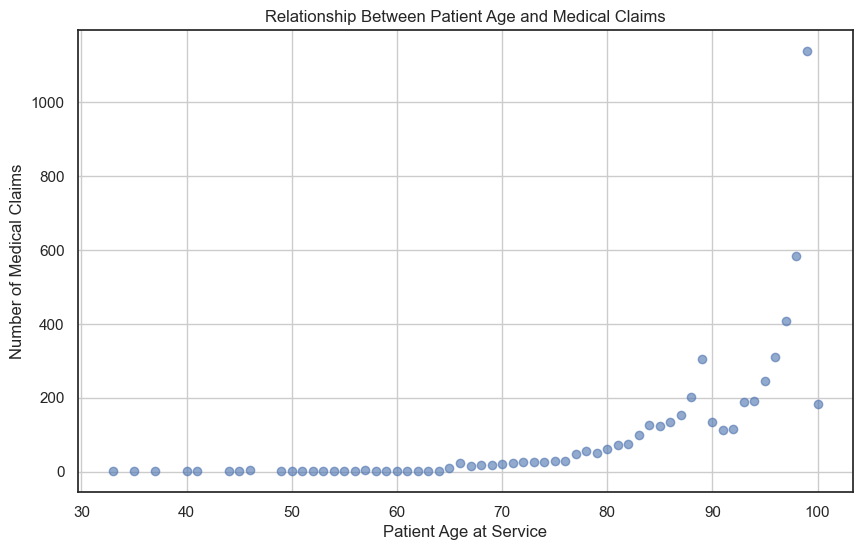

In [161]:
# Study the relationship between the patient ages (at the time of their service) and the counts of medical claims.
# Ensure datetime conversion
df_final_IOB['DOB'] = pd.to_datetime(df_final_IOB['DOB'], errors='coerce')
df_final_IOB['ClaimStartDt'] = pd.to_datetime(df_final_IOB['ClaimStartDt'], errors='coerce')

# Calculate patient age at the time of service
df_final_IOB['Patient_Age'] = (df_final_IOB['ClaimStartDt'] - df_final_IOB['DOB']).dt.days // 365  # Convert days to years

# Count medical claims per age
age_claims = df_final_IOB.groupby('Patient_Age').size().reset_index(name='Claim_Count')

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(age_claims['Patient_Age'], age_claims['Claim_Count'], alpha=0.6, color='b')
plt.xlabel("Patient Age at Service")
plt.ylabel("Number of Medical Claims")
plt.title("Relationship Between Patient Age and Medical Claims")
plt.grid(True)
plt.show()

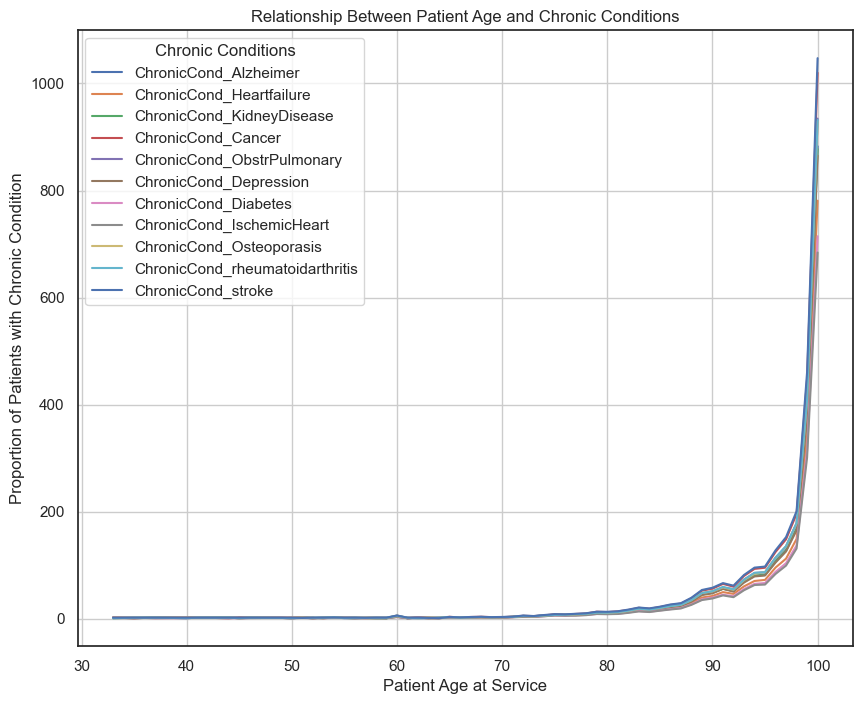

In [162]:
# Study the relationship between the patient age and their chornic conditions
# Ensure datetime conversion
df_final_IOB['DOB'] = pd.to_datetime(df_final_IOB['DOB'], errors='coerce')
df_final_IOB['ClaimStartDt'] = pd.to_datetime(df_final_IOB['ClaimStartDt'], errors='coerce')

# Calculate patient age at the time of service
df_final_IOB['Patient_Age'] = (df_final_IOB['ClaimStartDt'] - df_final_IOB['DOB']).dt.days // 365  # Convert days to years

# Define chronic conditions columns 
chronic_conditions = ['ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',]

# Aggregate chronic condition counts by patient age
age_chronic_conditions = df_final_IOB.groupby('Patient_Age')[chronic_conditions].mean().reset_index()

# Plot the relationship between age and chronic conditions
plt.figure(figsize=(10, 8))

# Plot each chronic condition
for condition in chronic_conditions:
    plt.plot(age_chronic_conditions['Patient_Age'], age_chronic_conditions[condition], label=condition)

plt.xlabel("Patient Age at Service")
plt.ylabel("Proportion of Patients with Chronic Condition")
plt.title("Relationship Between Patient Age and Chronic Conditions")
plt.legend(title="Chronic Conditions")
plt.grid(True)
plt.show()

In [163]:
df_final_IOB.isnull().sum()

Provider                           0
PotentialFraud                     0
BeneID                             0
ClaimID                            0
ClaimStartDt                       0
ClaimEndDt                         0
InscClaimAmtReimbursed             0
AttendingPhysician                 0
OperatingPhysician                 0
OtherPhysician                     0
AdmissionDt                        0
ClmAdmitDiagnosisCode              0
DeductibleAmtPaid                  0
DischargeDt                        0
DiagnosisGroupCode                 0
ClmDiagnosisCode_1                 0
ClmDiagnosisCode_2                 0
ClmDiagnosisCode_3                 0
ClmDiagnosisCode_4                 0
ClmDiagnosisCode_5                 0
ClmDiagnosisCode_6                 0
ClmDiagnosisCode_7                 0
ClmDiagnosisCode_8                 0
ClmDiagnosisCode_9                 0
ClmDiagnosisCode_10                0
ClmProcedureCode_1                 0
ClmProcedureCode_2                 0
C

In [164]:
df_final_IOB.columns

Index(['Provider', 'PotentialFraud', 'BeneID', 'ClaimID', 'ClaimStartDt',
       'ClaimEndDt', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'Hospital_Stay', 'IsIP',
       'IsOP', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_Obs

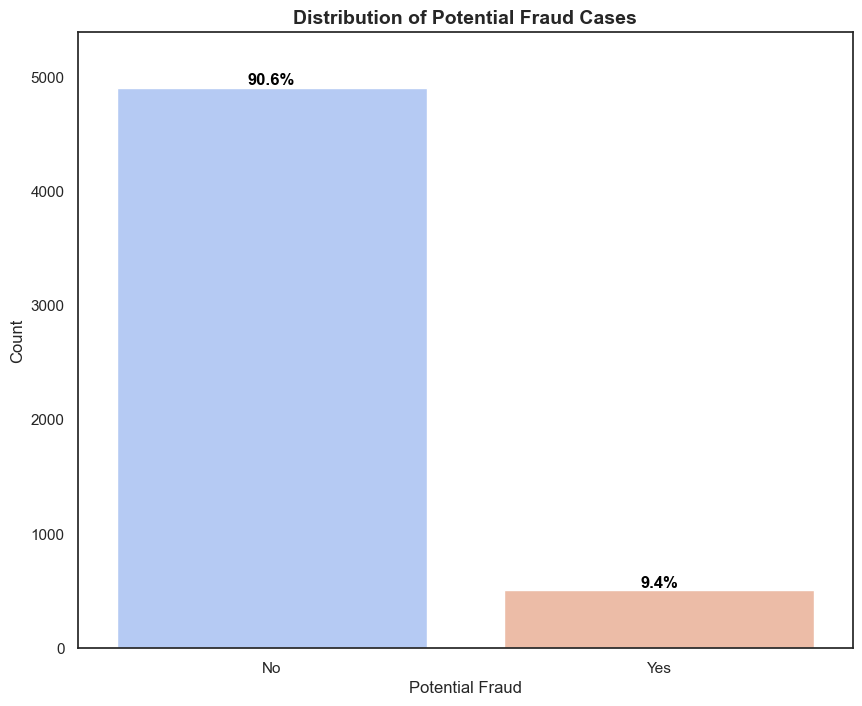

In [165]:
#Check the distribution of fraud vs non-fraud cases.
# Count total values
total = len(df_final_IOB)

# Create the count plot
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='PotentialFraud', data=df_final_IOB, palette='coolwarm')

# Add percentages on top of bars
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'  # Calculate percentage
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Title and formatting
plt.title('Distribution of Potential Fraud Cases', fontsize=14, fontweight='bold')
plt.xlabel('Potential Fraud', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.ylim(0, max([p.get_height() for p in ax.patches]) * 1.1)  # Extend y-axis for labels
plt.show()

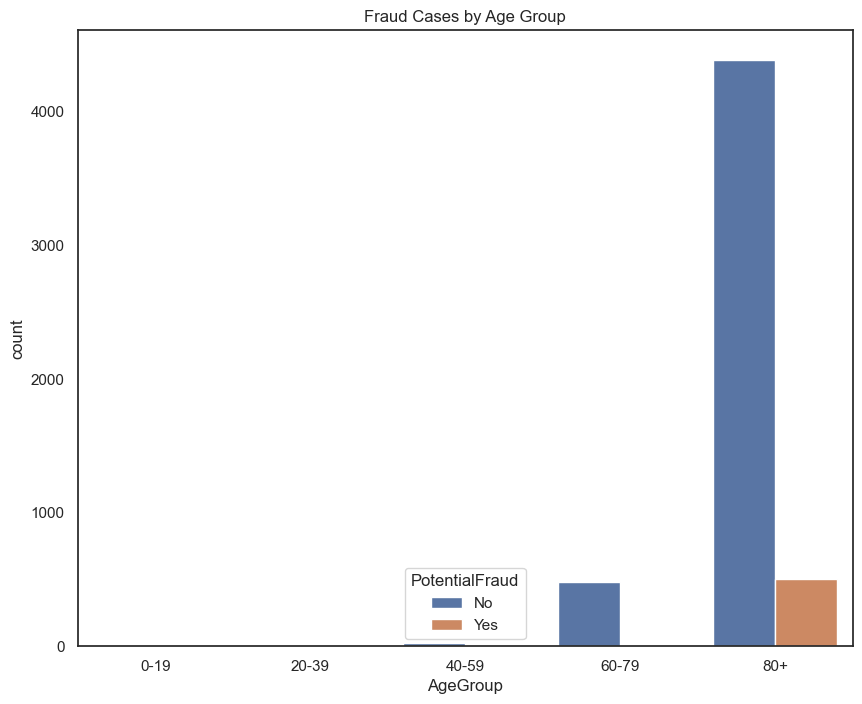

In [166]:
# Create age groups and analyze fraud cases in each group
df_final_IOB['AgeGroup'] = pd.cut(df_final_IOB['Patient_Age'], 
                                  bins=[0, 20, 40, 60, 80, 100], 
                                  labels=['0-19', '20-39', '40-59', '60-79', '80+'], 
                                  ordered=True)

# Ensure all categories are retained in counts
df_final_IOB['AgeGroup'] = df_final_IOB['AgeGroup'].astype(pd.CategoricalDtype(ordered=True))

# Create the count plot for fraud cases by age group
import warnings
warnings.simplefilter("ignore", FutureWarning)

plt.figure(figsize=(10, 8))
sns.countplot(x='AgeGroup', hue='PotentialFraud', data=df_final_IOB,)
plt.title('Fraud Cases by Age Group')
plt.show()

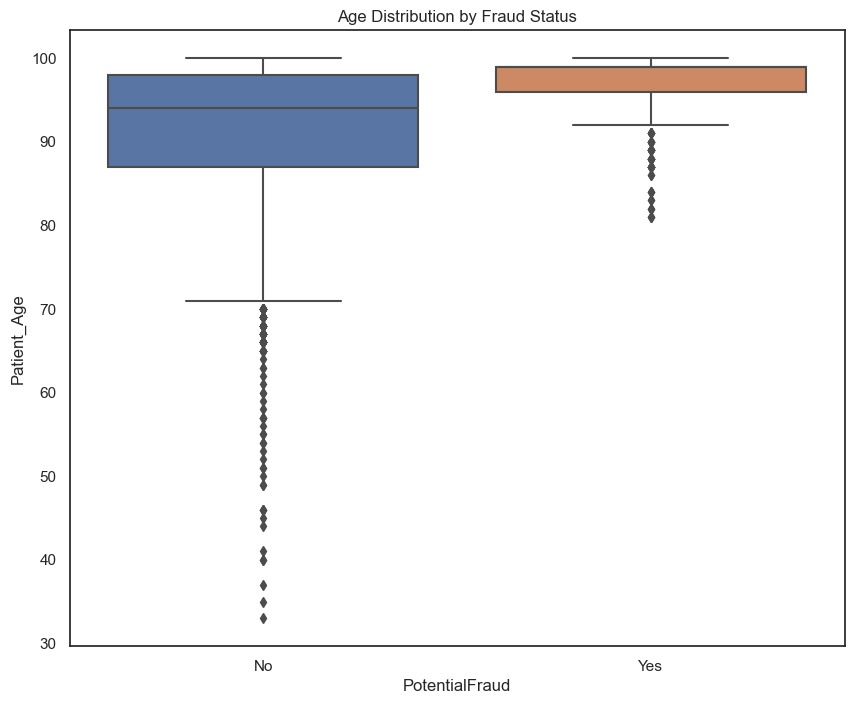

In [167]:
# Compare the distribution of patient age between fraud and non-fraud cases.
plt.figure(figsize=(10,8))
sns.boxplot(x='PotentialFraud', y='Patient_Age', data=df_final_IOB)
plt.title('Age Distribution by Fraud Status')
plt.show()

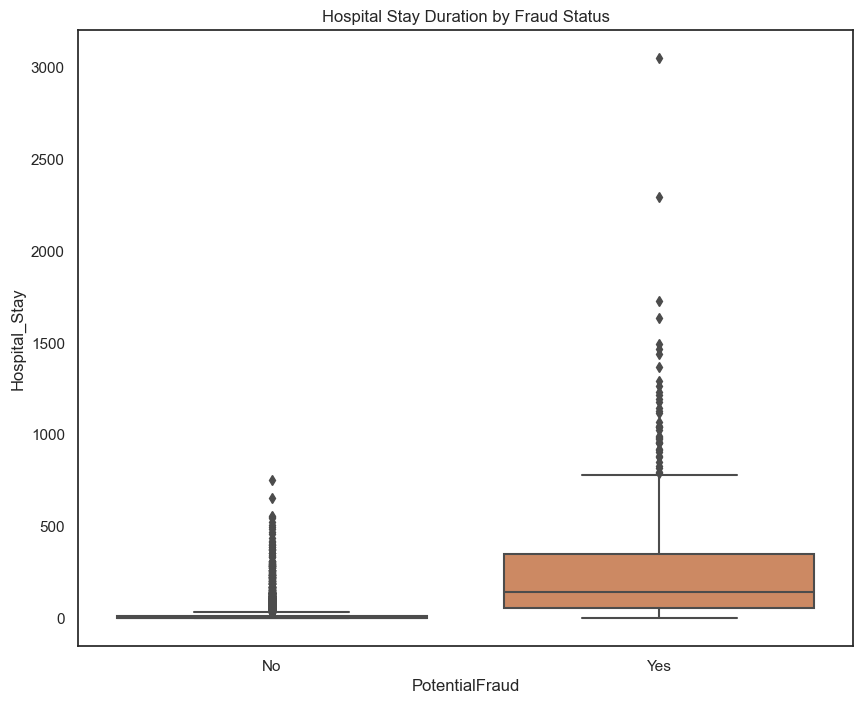

In [168]:
# Hospital stay duration with Fraud status cases
plt.figure(figsize=(10,8))
sns.boxplot(x='PotentialFraud', y='Hospital_Stay', data=df_final_IOB)
plt.title('Hospital Stay Duration by Fraud Status')
plt.show()

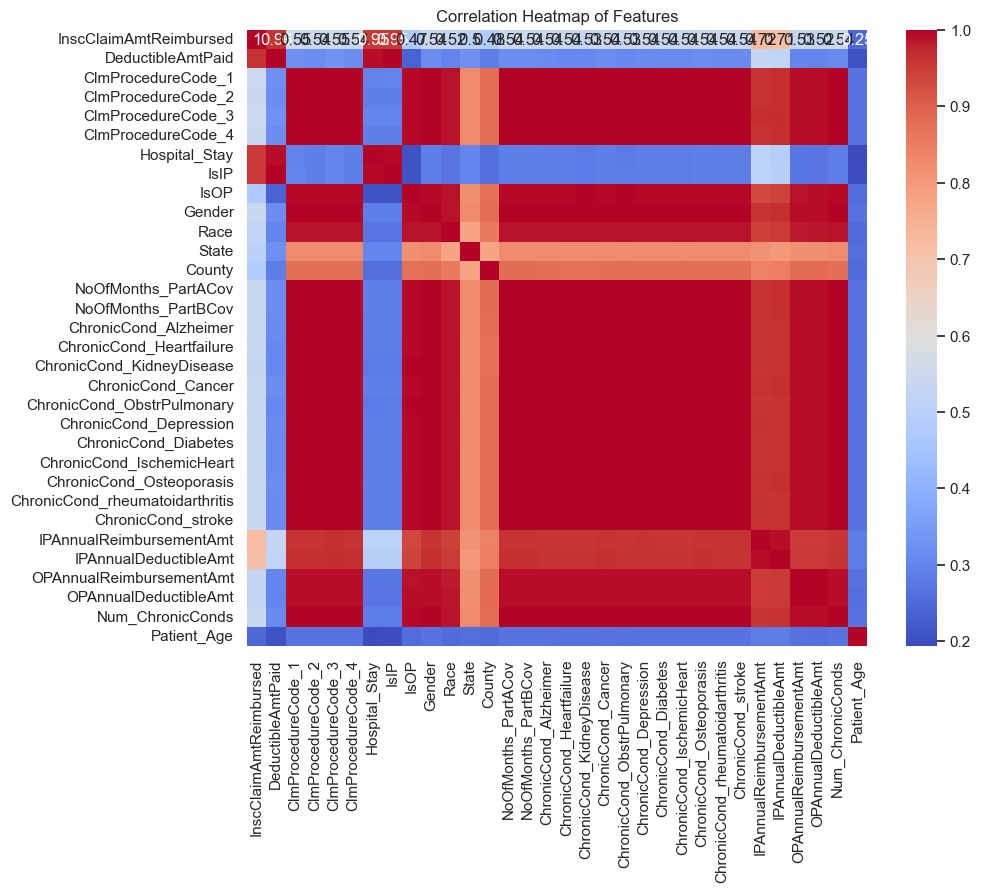

In [169]:
numeric_df = df_final_IOB.select_dtypes(include=['number'])
# Compute the correlation matrix for numeric columns only
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

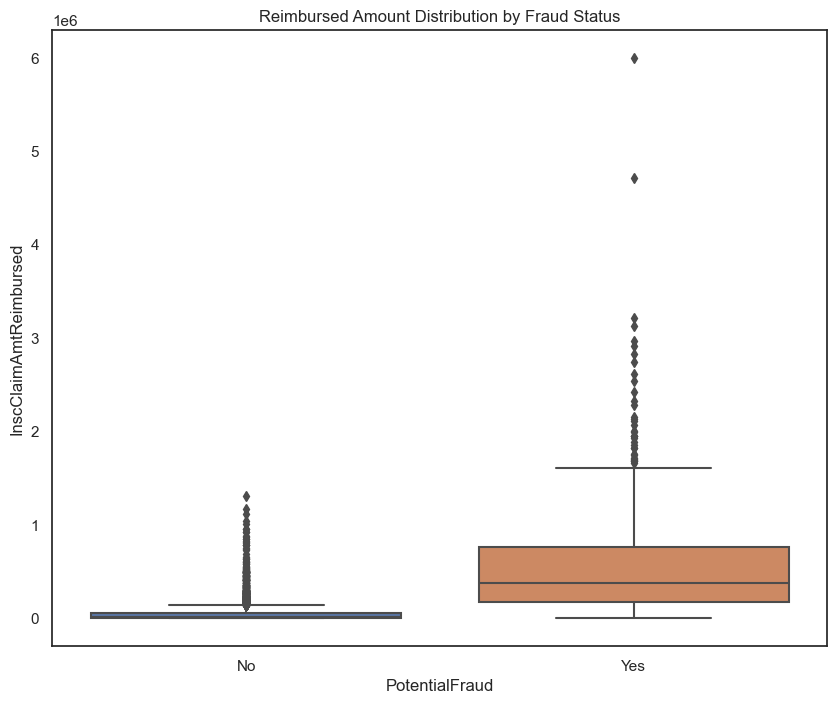

In [170]:
# Check the amount reimbursed for fraud and non-fraud cases.
plt.figure(figsize=(10,8))
sns.boxplot(x='PotentialFraud', y='InscClaimAmtReimbursed', data=df_final_IOB)
plt.title('Reimbursed Amount Distribution by Fraud Status')
plt.show()

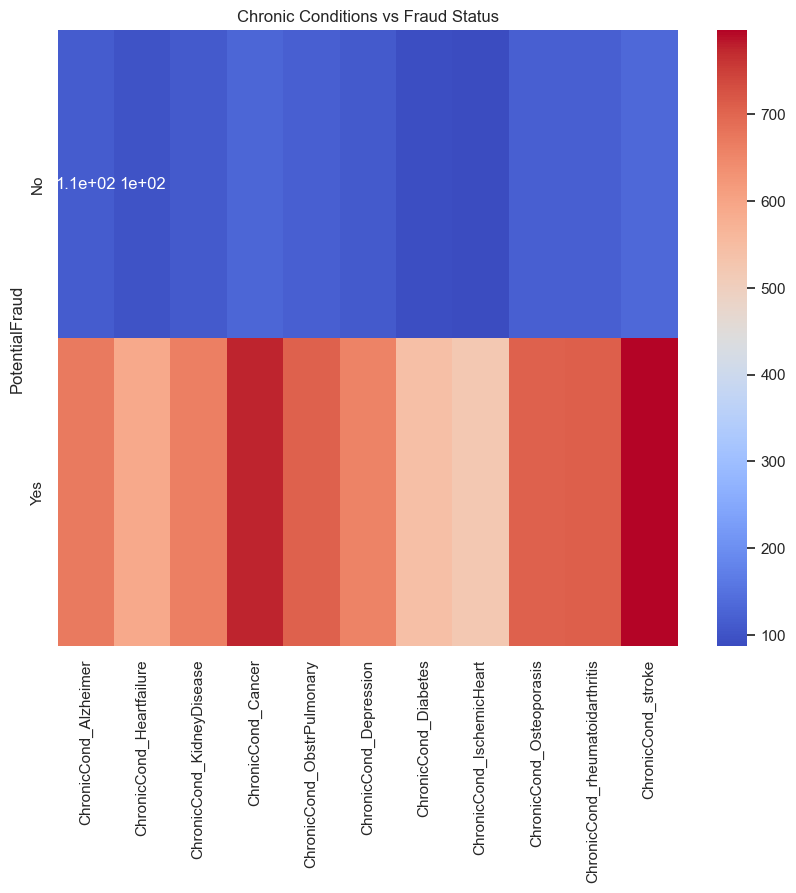

In [171]:
# Visualize how chronic conditions related to fraud cases.
chronic_columns = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 
                   'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                   'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 
                   'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

chronic_df = df_final_IOB[chronic_columns + ['PotentialFraud']]
plt.figure(figsize=(10,8))
sns.heatmap(chronic_df.groupby('PotentialFraud').mean(), annot=True, cmap='coolwarm')
plt.title('Chronic Conditions vs Fraud Status')
plt.show()

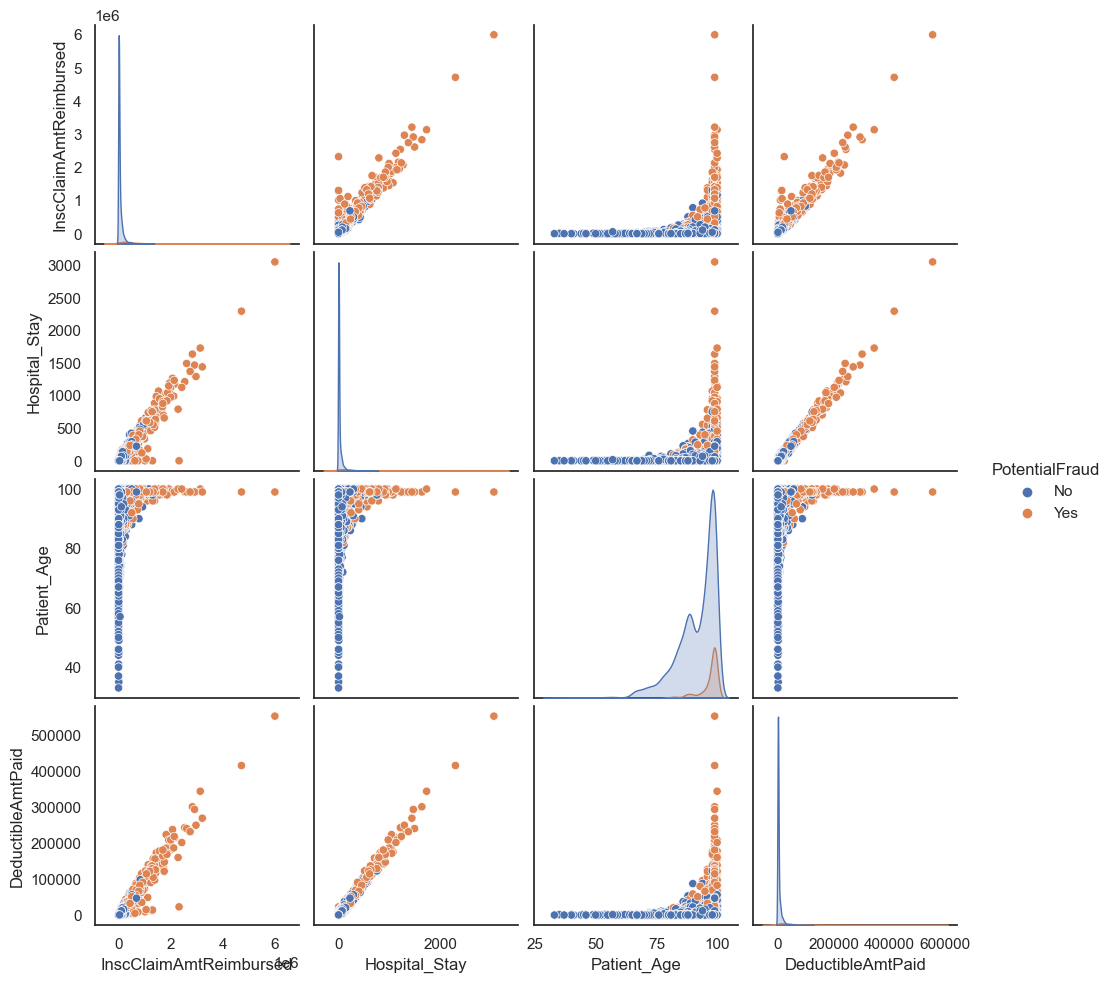

In [172]:
# Create a pairplot to check the relationships between key features, colored by fraud status.
# Suppress FutureWarnings temporarily
warnings.simplefilter("ignore", FutureWarning)

# Replace inf values with NaN
df_final_IOB.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

# Pairplot for selected features, color-coded by 'PotentialFraud'
sns.pairplot(df_final_IOB[['InscClaimAmtReimbursed', 'Hospital_Stay', 'Patient_Age', 'DeductibleAmtPaid', 'PotentialFraud']], hue='PotentialFraud')

# Show the plot
plt.show()

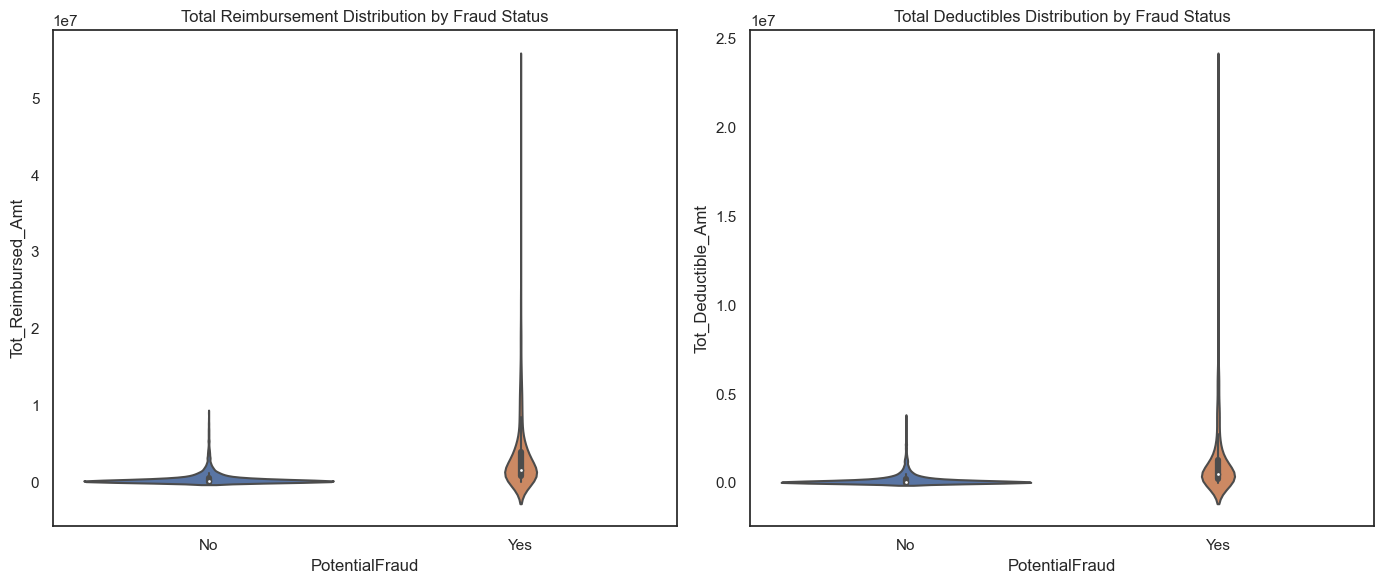

In [173]:
#Check the distribution of Reimbursement and deductibles in fraud and non-fraud cases.
# Creating one column for reimbursement and deductible total amounts
df_final_IOB['Tot_Reimbursed_Amt'] = df_final_IOB['IPAnnualReimbursementAmt'] + df_final_IOB['OPAnnualReimbursementAmt']	
df_final_IOB['Tot_Deductible_Amt'] = df_final_IOB['IPAnnualDeductibleAmt'] + df_final_IOB['OPAnnualReimbursementAmt'] 	

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first violin plot (Inpatient Deductibles)
sns.violinplot(x='PotentialFraud', y='Tot_Reimbursed_Amt', data=df_final_IOB, ax=axes[0])
axes[0].set_title('Total Reimbursement Distribution by Fraud Status')

# Plot the second violin plot (Outpatient Deductibles)
sns.violinplot(x='PotentialFraud', y='Tot_Deductible_Amt', data=df_final_IOB, ax=axes[1])
axes[1].set_title('Total Deductibles Distribution by Fraud Status')

# Display the plots
plt.tight_layout()
plt.show()

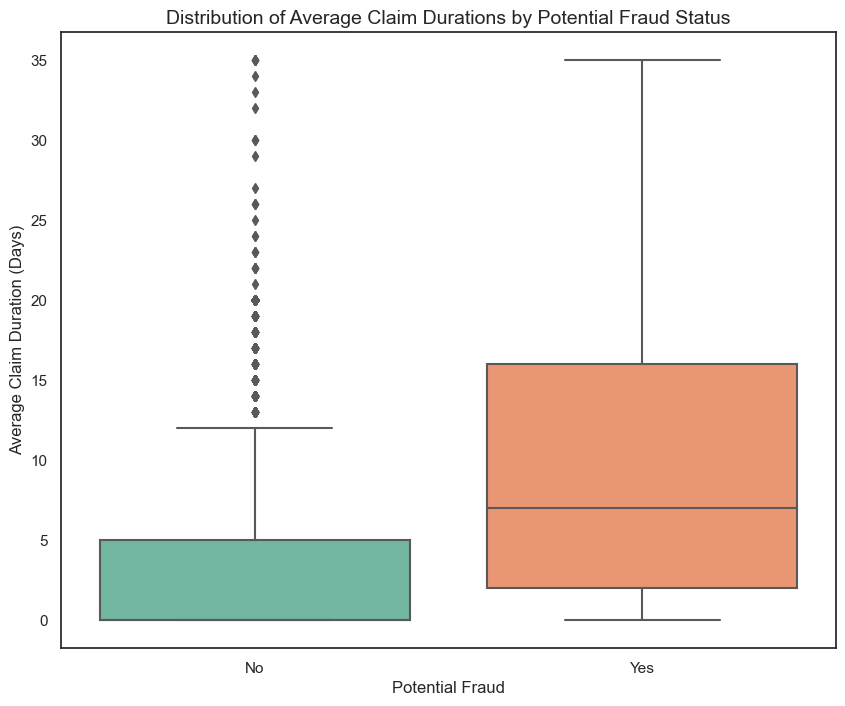

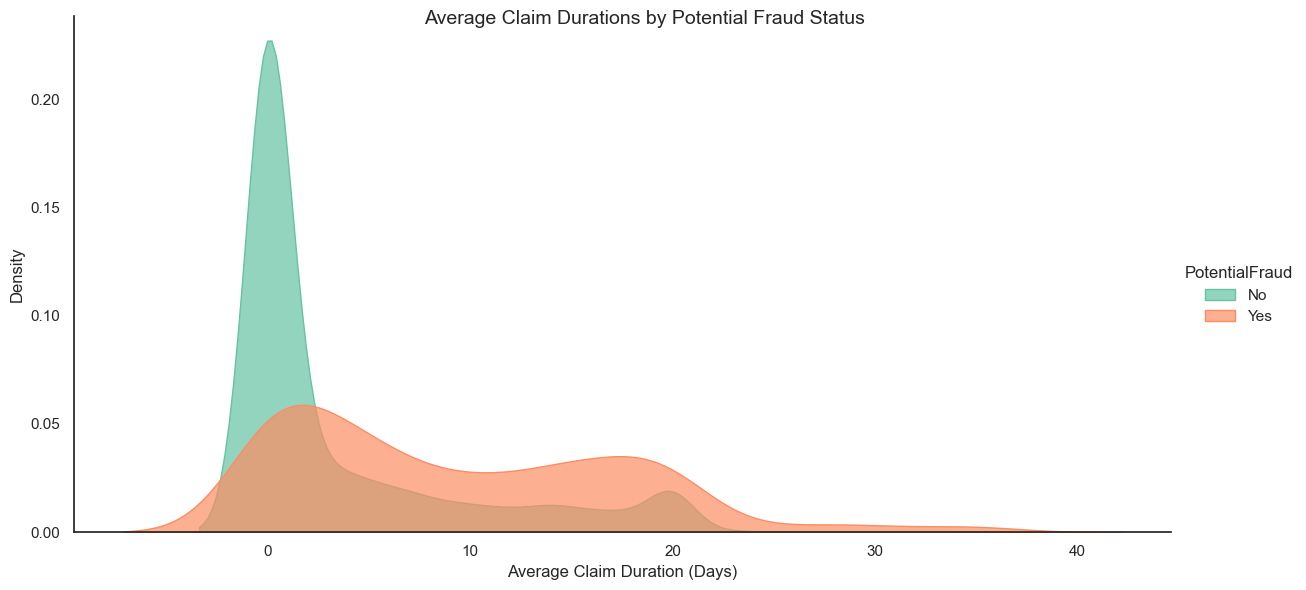

In [174]:
#To study the distribution of the durations of average insurance claims for providers and compare the differences between 
#potential fraud (PotentialFraud == 'Yes') and non-potential fraud (PotentialFraud == 'No') providers, you can use box plots or violin plots.

# Ensure ClaimStartDt and ClaimEndDt are in datetime format
df_final_IOB['ClaimStartDt'] = pd.to_datetime(df_final_IOB['ClaimStartDt'])
df_final_IOB['ClaimEndDt'] = pd.to_datetime(df_final_IOB['ClaimEndDt'])

# Calculate claim duration in days
df_final_IOB['ClaimDuration'] = (df_final_IOB['ClaimEndDt'] - df_final_IOB['ClaimStartDt']).dt.days

# Group by provider and calculate the average claim duration
provider_claim_durations = df_final_IOB.groupby('Provider')['ClaimDuration'].mean().reset_index()
provider_claim_durations.rename(columns={'ClaimDuration': 'AvgClaimDuration'}, inplace=True)

# Merge with the PotentialFraud flag
provider_data = provider_claim_durations.merge(df_final_IOB[['Provider', 'PotentialFraud']].drop_duplicates(), on='Provider')

# Plot the distribution using boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x='PotentialFraud', y='AvgClaimDuration', data=provider_data, palette='Set2')
plt.title('Distribution of Average Claim Durations by Potential Fraud Status', fontsize=14)
plt.xlabel('Potential Fraud', fontsize=12)
plt.ylabel('Average Claim Duration (Days)', fontsize=12)
plt.show()

# Plot the distribution using Facet Grid of KDE Plots
g = sns.FacetGrid(provider_data, hue='PotentialFraud', height=6, aspect=2, palette='Set2')
g.map(sns.kdeplot, 'AvgClaimDuration', fill=True, alpha=0.7)
g.add_legend()
g.set_axis_labels('Average Claim Duration (Days)', 'Density')
g.fig.suptitle('Average Claim Durations by Potential Fraud Status', fontsize=14)
plt.show()

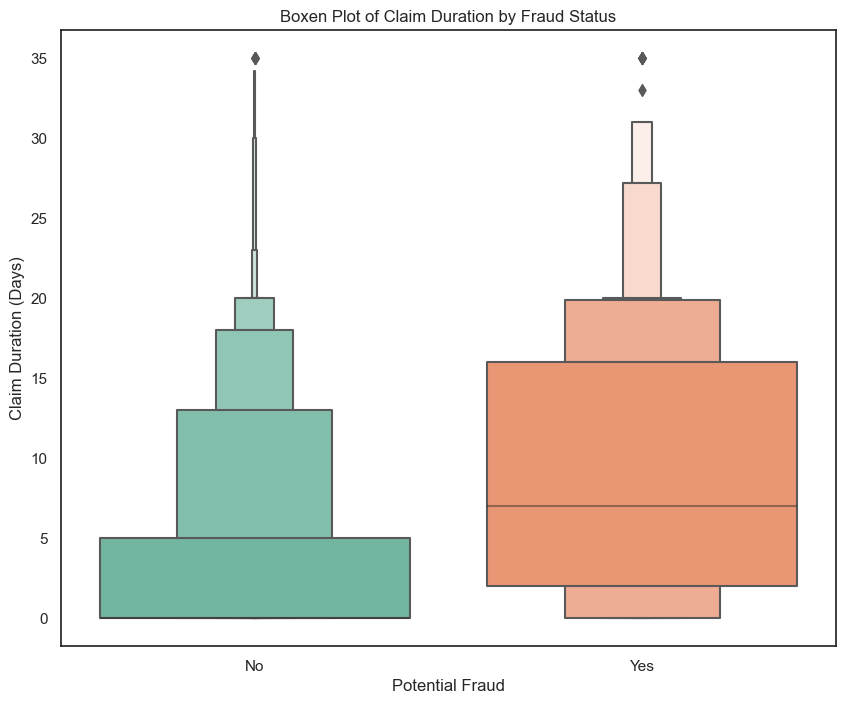

In [175]:
# Comparing the claim durations for providers flagged as fraud vs. non-fraud.
plt.figure(figsize=(10, 8))
sns.boxenplot(data=df_final_IOB, x='PotentialFraud', y='ClaimDuration', palette='Set2')
plt.title('Boxen Plot of Claim Duration by Fraud Status')
plt.xlabel('Potential Fraud')
plt.ylabel('Claim Duration (Days)')
plt.show()

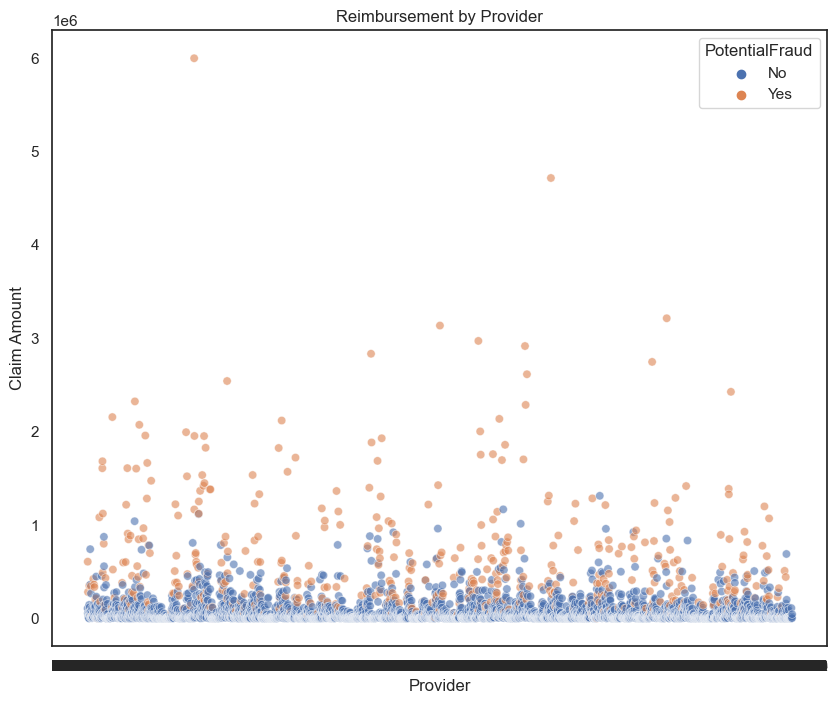

In [176]:
#Scatter plot to detect providers with unusually high reimbursement amounts.
plt.figure(figsize=(10, 8)) 
sns.scatterplot(data=df_final_IOB, x='Provider', y='InscClaimAmtReimbursed', hue='PotentialFraud', alpha=0.6)
plt.title('Reimbursement by Provider')
plt.xlabel('Provider')
plt.ylabel('Claim Amount')
plt.show()

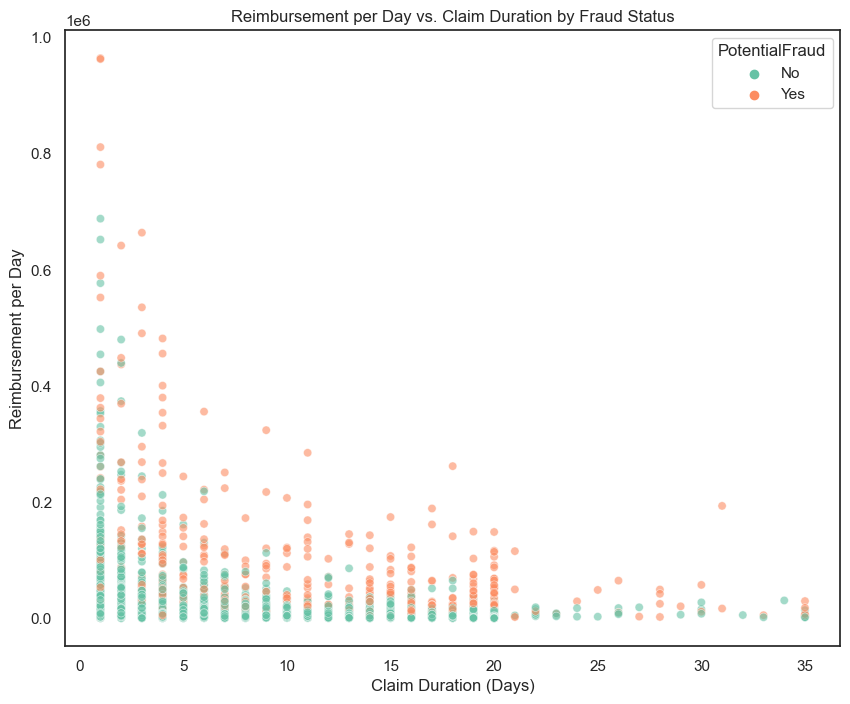

In [177]:
#visualize the relationship between Claim Duration and Reimbursement per Day
# Calculate Reimbursement per Day
df_final_IOB['ReimbursementPerDay'] = df_final_IOB['InscClaimAmtReimbursed'] / df_final_IOB['ClaimDuration']
# Fill missing values with the median
df_final_IOB['ReimbursementPerDay'].fillna(df_final_IOB['ReimbursementPerDay'].median(), inplace=True)
sns.scatterplot(data=df_final_IOB, x='ClaimDuration', y='ReimbursementPerDay', hue='PotentialFraud', alpha=0.6, palette='Set2')
plt.title('Reimbursement per Day vs. Claim Duration by Fraud Status')
plt.xlabel('Claim Duration (Days)')
plt.ylabel('Reimbursement per Day')
plt.show()

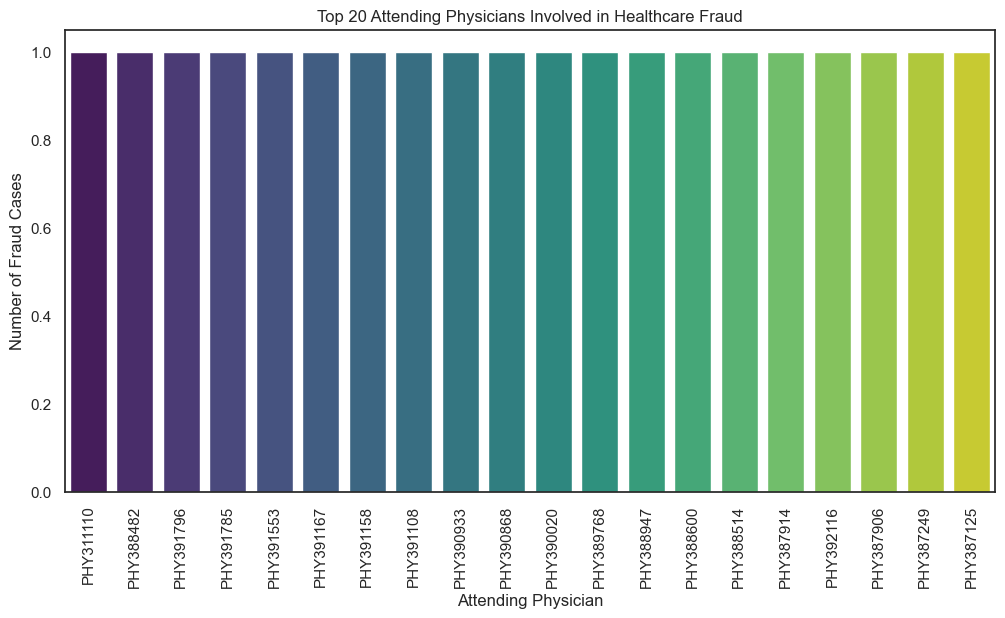

In [178]:
# Count fraud cases by attending physician and sort in descending order to get the top 20
top_20_physicians = df_final_IOB[df_final_IOB['PotentialFraud'] == 'Yes'].groupby('AttendingPhysician').size().sort_values(ascending=False).head(20)

# Plot bar graph in descending order
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_physicians.index, y=top_20_physicians.values, palette='viridis')
plt.title('Top 20 Attending Physicians Involved in Healthcare Fraud')
plt.xlabel('Attending Physician')
plt.ylabel('Number of Fraud Cases')
plt.xticks(rotation=90)
plt.show()

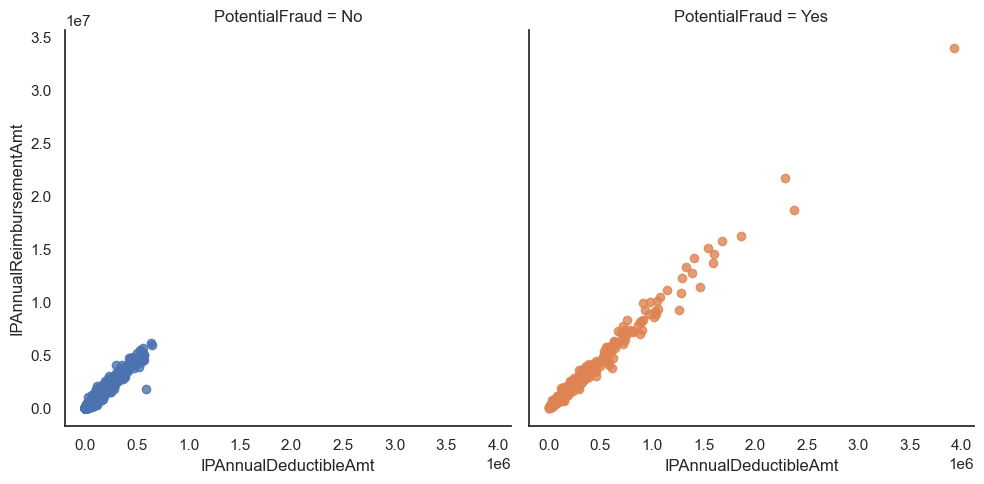

In [179]:
## Lets Plot IPAnnualDeductibleAmt and IPAnnualReimbursementAmt in both fraud and non Fraud Categoories

sns.set(rc={'figure.figsize':(10,8)},style='white')

sns.lmplot(x='IPAnnualDeductibleAmt',y='IPAnnualReimbursementAmt',hue='PotentialFraud',
           col='PotentialFraud',fit_reg=False,data=df_final_IOB)


#plt.title('IPAnnualDeductibleAmt and IPAnnualReimbursementAmt in both fraud and non Fraud Categoories')

plt.savefig('IPAnnualDeductibleAmtandIPAnnualReimbursementAmtinbothfraudandnonFraud')

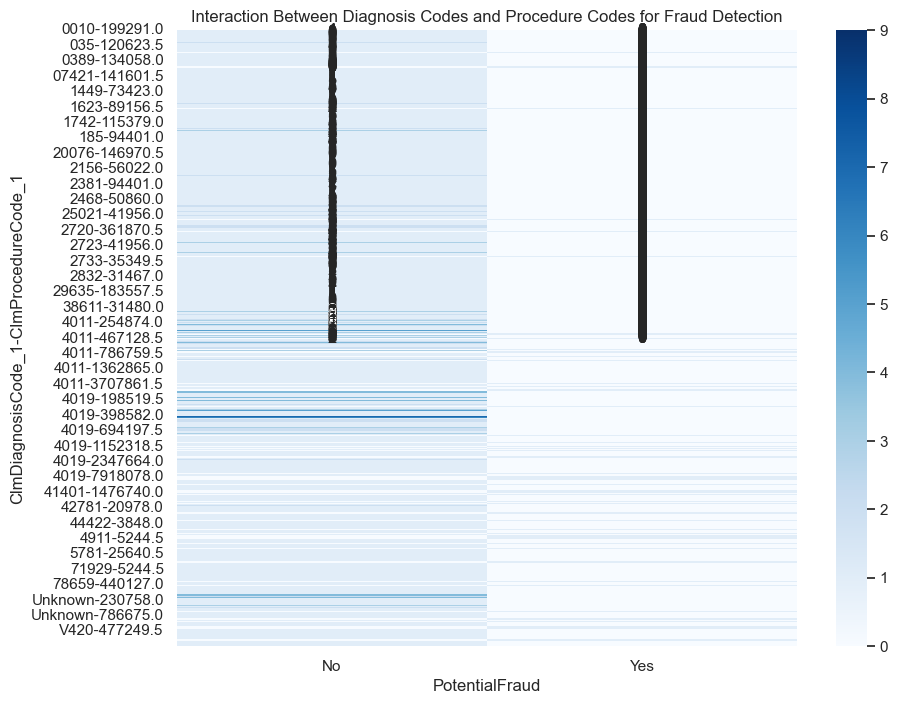

In [180]:
diag_proc_df = df_final_IOB[['ClmDiagnosisCode_1', 'ClmProcedureCode_1', 'PotentialFraud']]
diag_proc_df = diag_proc_df.groupby(['ClmDiagnosisCode_1', 'ClmProcedureCode_1', 'PotentialFraud']).size().unstack(fill_value=0)
sns.heatmap(diag_proc_df, annot=True, cmap='Blues')
plt.title('Interaction Between Diagnosis Codes and Procedure Codes for Fraud Detection')
plt.show()

In [181]:
df_final_IOB.isnull().sum()

Provider               0
PotentialFraud         0
BeneID                 0
ClaimID                0
ClaimStartDt           0
                      ..
AgeGroup               0
Tot_Reimbursed_Amt     0
Tot_Deductible_Amt     0
ClaimDuration          0
ReimbursementPerDay    0
Length: 65, dtype: int64

In [182]:
df_final_IOB.columns

Index(['Provider', 'PotentialFraud', 'BeneID', 'ClaimID', 'ClaimStartDt',
       'ClaimEndDt', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'Hospital_Stay', 'IsIP',
       'IsOP', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_Obs

In [183]:
df_final_IOB.shape

(5410, 65)

Accuracy: 0.9270
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       977
           1       0.76      0.36      0.49       105

    accuracy                           0.93      1082
   macro avg       0.85      0.67      0.73      1082
weighted avg       0.92      0.93      0.92      1082


Top 10 Most Important Features:
                            Feature  Importance
0            InscClaimAmtReimbursed    2.487042
17627        OtherPhysician_Unknown    1.048363
18940       ClmDiagnosisCode_1_5990    0.976671
19274      ClmDiagnosisCode_2_42731    0.866063
19450      ClmDiagnosisCode_3_25000    0.860226
10662             ClaimID_CLM126598    0.753325
4591              BeneID_BENE102088    0.753325
2442              Provider_PRV54808    0.753325
14956  AttendingPhysician_PHY368947    0.753325
10161             ClaimID_CLM119024    0.747913


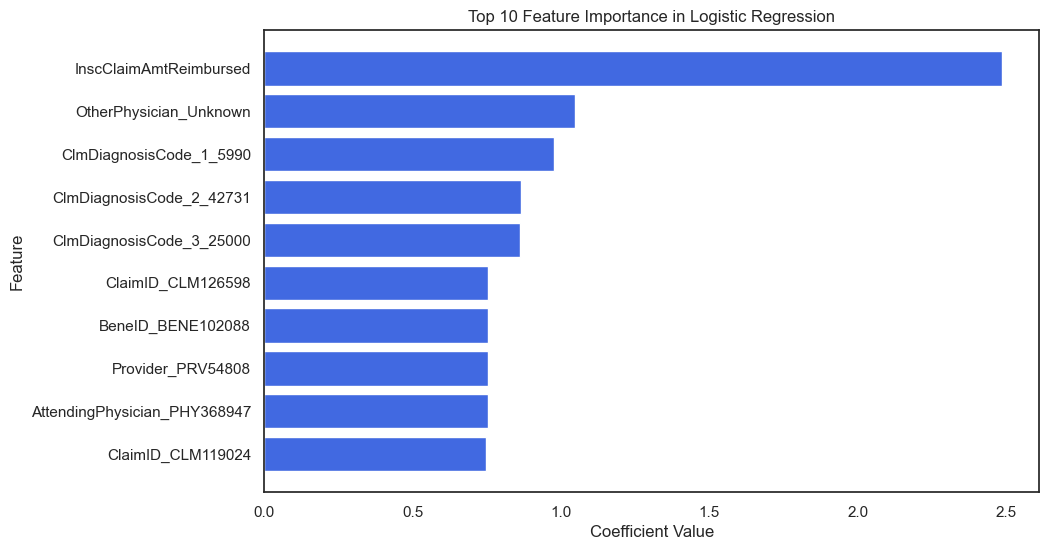

In [201]:
#Modeling
# Logistic regression model
# Step 1: Replace infinities with NaN
df_final_IOB.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Define features and target variable
X = df_final_IOB.drop(columns=['PotentialFraud'])
y = df_final_IOB['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Step 3: Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Step 4: Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing numeric values with median
    ('scaler', StandardScaler())  # Scale numeric data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Step 5: Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 6: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Create and train Logistic Regression model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=1000))])

model.fit(X_train, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print evaluation results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', report)

# Step 9: Extract Feature Importance
# Get feature names after preprocessing
encoded_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
all_feature_names = list(numeric_features) + encoded_feature_names

# Get model coefficients
feature_importance = model.named_steps['classifier'].coef_[0]

# Create DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Step 10: Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='royalblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

Accuracy: 0.9196
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       977
           1       0.63      0.41      0.50       105

    accuracy                           0.92      1082
   macro avg       0.79      0.69      0.73      1082
weighted avg       0.91      0.92      0.91      1082


Top 10 Most Important Features:
                     Feature  Importance
0     InscClaimAmtReimbursed    0.634272
11                     State    0.052754
6              Hospital_Stay    0.029994
12                    County    0.028609
1          DeductibleAmtPaid    0.023870
2         ClmProcedureCode_1    0.016990
17  OPAnnualReimbursementAmt    0.016557
23             ClaimDuration    0.013090
16     IPAnnualDeductibleAmt    0.011880
24       ReimbursementPerDay    0.010435


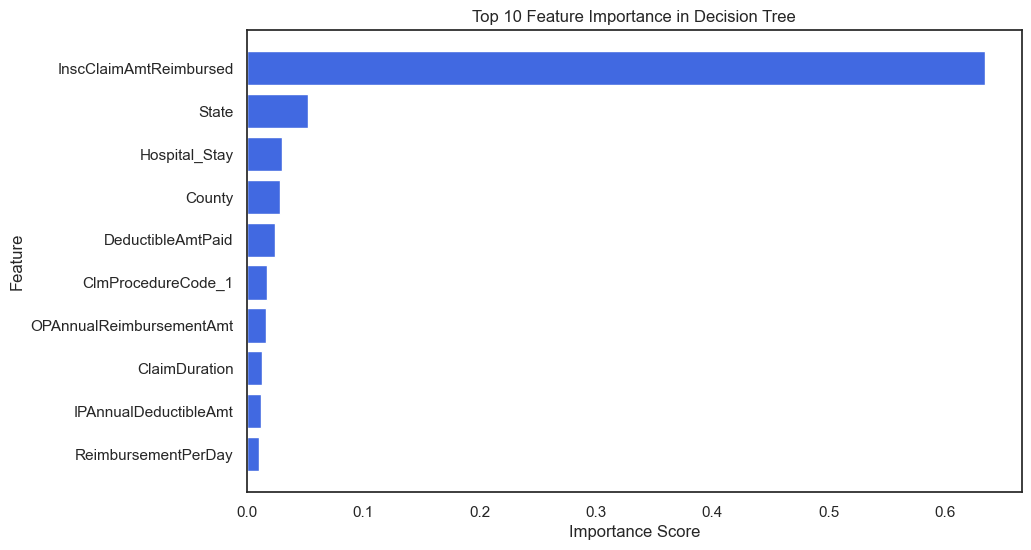

In [202]:
# Decision Tree (DecisionTreeClassifier) model 
# Step 1: Replace infinities with NaN
df_final_IOB.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Define features and target variable
X = df_final_IOB.drop(columns=['PotentialFraud'])
y = df_final_IOB['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Step 3: Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Step 4: Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing numeric values with median
    ('scaler', StandardScaler())  # Scale numeric data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Step 5: Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 6: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Create and train Decision Tree model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(random_state=42, max_depth=10))])  # Adjust max_depth as needed

model.fit(X_train, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print evaluation results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', report)

# Step 9: Extract Feature Importance
# Get feature names after preprocessing
encoded_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
all_feature_names = list(numeric_features) + encoded_feature_names

# Get feature importances
feature_importance = model.named_steps['classifier'].feature_importances_

# Create DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Step 10: Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in Decision Tree')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

Accuracy: 0.9122
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       977
           1       1.00      0.10      0.17       105

    accuracy                           0.91      1082
   macro avg       0.96      0.55      0.56      1082
weighted avg       0.92      0.91      0.88      1082


Top 10 Most Important Features:
                     Feature  Importance
6              Hospital_Stay    0.058356
0     InscClaimAmtReimbursed    0.057260
24       ReimbursementPerDay    0.047537
1          DeductibleAmtPaid    0.047081
5         ClmProcedureCode_4    0.038358
21        Tot_Reimbursed_Amt    0.034487
22        Tot_Deductible_Amt    0.032843
16     IPAnnualDeductibleAmt    0.029322
15  IPAnnualReimbursementAmt    0.029273
19          Num_ChronicConds    0.028900


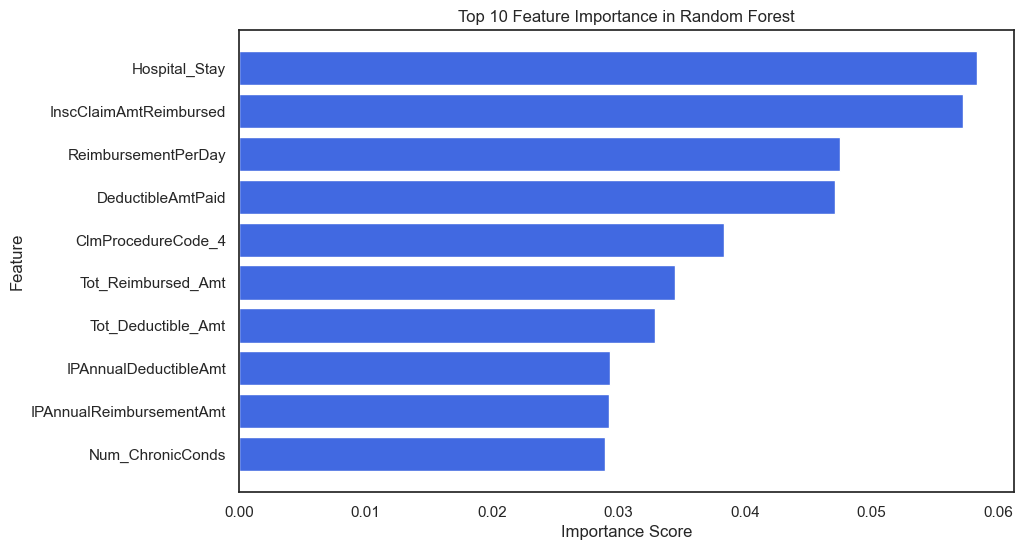

In [203]:
#Random Forest (RandomForestClassifier) model
# Step 1: Replace infinities with NaN
df_final_IOB.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Define features and target variable
X = df_final_IOB.drop(columns=['PotentialFraud'])
y = df_final_IOB['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Step 3: Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Step 4: Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing numeric values with median
    ('scaler', StandardScaler())  # Scale numeric data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Step 5: Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 6: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Create and train Random Forest model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10))])  # Adjust max_depth as needed

model.fit(X_train, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print evaluation results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', report)

# Step 9: Extract Feature Importance
# Get feature names after preprocessing
encoded_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
all_feature_names = list(numeric_features) + encoded_feature_names

# Get feature importances
feature_importance = model.named_steps['classifier'].feature_importances_

# Create DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Step 10: Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

Accuracy: 0.9159
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       977
           1       0.60      0.41      0.49       105

    accuracy                           0.92      1082
   macro avg       0.77      0.69      0.72      1082
weighted avg       0.91      0.92      0.91      1082


Top 10 Most Important Features:
                           Feature  Importance
0           InscClaimAmtReimbursed    0.246257
19450     ClmDiagnosisCode_3_25000    0.036110
3               ClmProcedureCode_2    0.029638
2               ClmProcedureCode_1    0.028561
6                    Hospital_Stay    0.025491
17805  ClmAdmitDiagnosisCode_78650    0.024297
18088      ClmDiagnosisCode_1_0389    0.023191
22              Tot_Deductible_Amt    0.022365
20093      ClmDiagnosisCode_6_4019    0.021930
19999   ClmDiagnosisCode_5_Unknown    0.021857


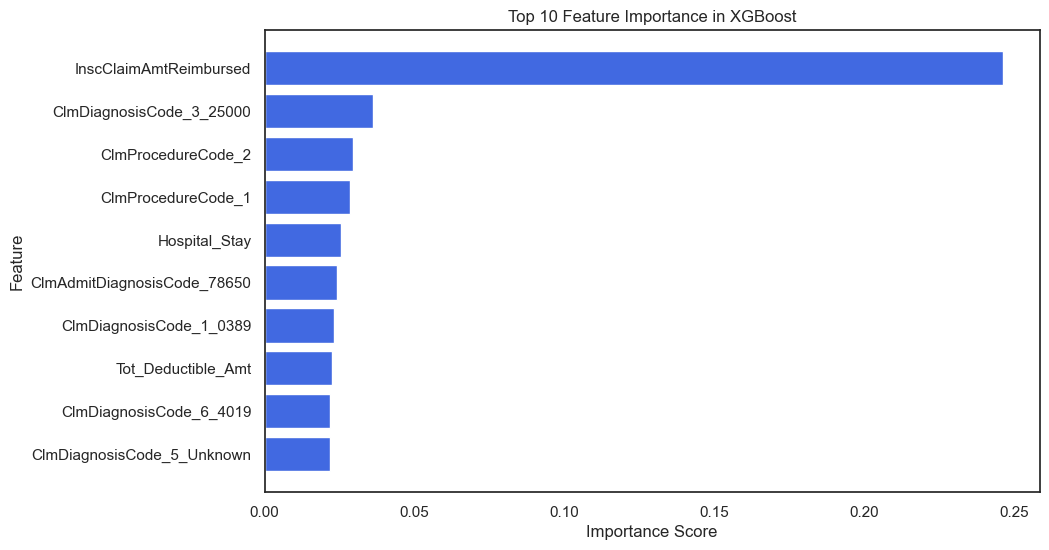

In [204]:
# XGBoost (XGBClassifier) model
# Step 1: Replace infinities with NaN
df_final_IOB.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Define features and target variable
X = df_final_IOB.drop(columns=['PotentialFraud'])
y = df_final_IOB['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Step 3: Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Step 4: Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing numeric values with median
    ('scaler', StandardScaler())  # Scale numeric data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Step 5: Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 6: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Create and train XGBoost model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(n_estimators=100, random_state=42, max_depth=10, eval_metric='logloss'))])  # Adjust max_depth as needed

model.fit(X_train, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print evaluation results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', report)

# Step 9: Extract Feature Importance
# Get feature names after preprocessing
encoded_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
all_feature_names = list(numeric_features) + encoded_feature_names

# Get feature importances
feature_importance = model.named_steps['classifier'].feature_importances_

# Create DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Step 10: Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

[LightGBM] [Info] Number of positive: 405, number of negative: 3923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093577 -> initscore=-2.270725
[LightGBM] [Info] Start training from score -2.270725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

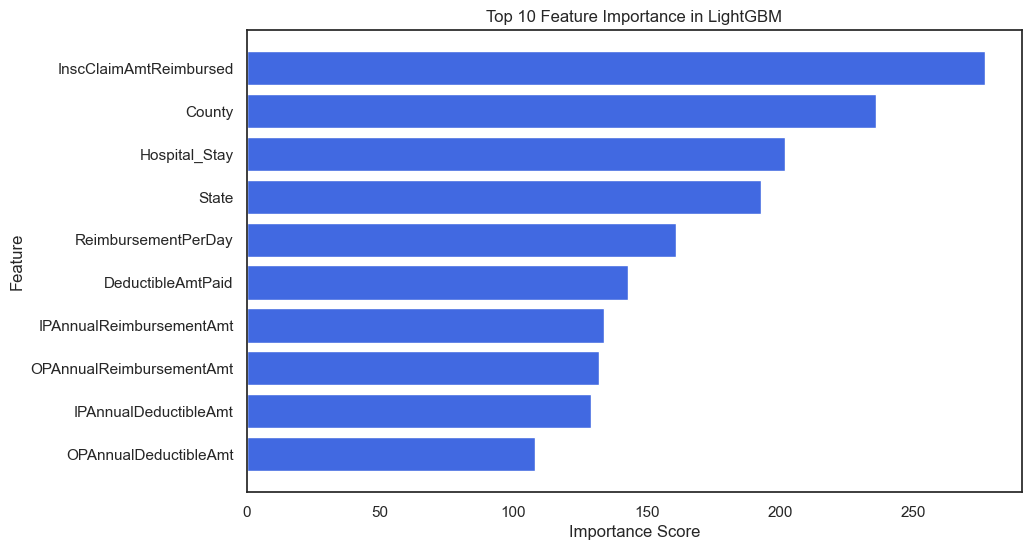

In [194]:
#LightGBM  model 
# Step 1: Replace infinities with NaN
df_final_IOB.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Define features and target variable
X = df_final_IOB.drop(columns=['PotentialFraud'])
y = df_final_IOB['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Step 3: Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Step 4: Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing numeric values with median
    ('scaler', StandardScaler())  # Scale numeric data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Step 5: Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 6: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Create and train LightGBM model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LGBMClassifier(n_estimators=100, random_state=42, max_depth=10))])  # Adjust max_depth as needed

model.fit(X_train, y_train)

# Step 8: Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print evaluation results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', report)

# Step 9: Extract Feature Importance
# Get feature names after preprocessing
encoded_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
all_feature_names = list(numeric_features) + encoded_feature_names

# Get feature importances
feature_importance = model.named_steps['classifier'].feature_importances_

# Create DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Step 10: Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in LightGBM')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

Accuracy: 0.9205
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       977
           1       0.65      0.40      0.49       105

    accuracy                           0.92      1082
   macro avg       0.79      0.69      0.73      1082
weighted avg       0.91      0.92      0.91      1082

Number of Features: 47
Number of Feature Importances: 64

Top 10 Most Important Features:
                Feature  Importance
11                State    7.795436
5    ClmProcedureCode_4    7.213970
30       OtherPhysician    6.601586
33   ClmDiagnosisCode_1    6.449244
39   ClmDiagnosisCode_7    5.602262
4    ClmProcedureCode_3    5.009818
14  NoOfMonths_PartBCov    4.498341
9                Gender    4.359859
38   ClmDiagnosisCode_6    3.920109
34   ClmDiagnosisCode_2    3.613372


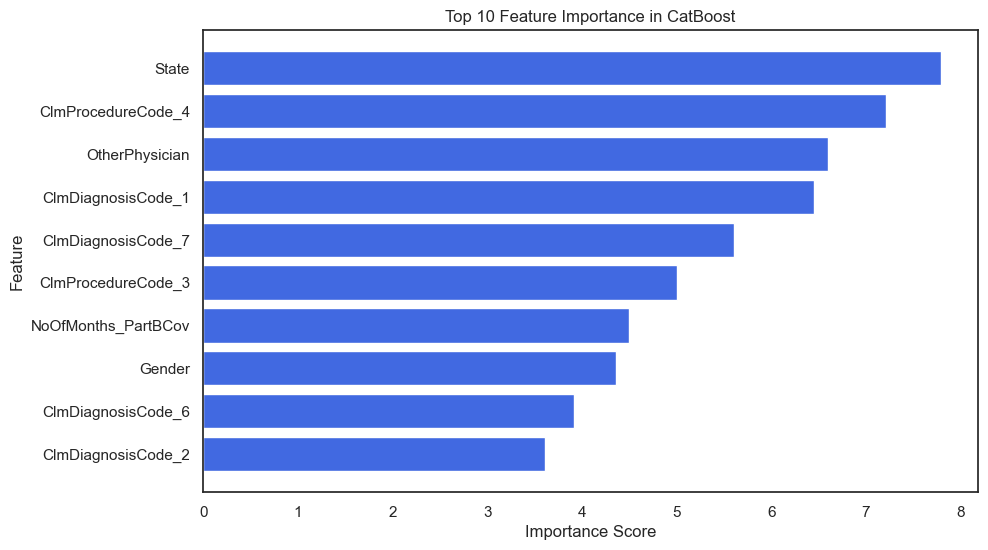

In [210]:
# Step 1: Replace infinities with NaN
df_final_IOB.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Define features and target variable
X = df_final_IOB.drop(columns=['PotentialFraud'])
y = df_final_IOB['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Step 3: Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Step 4: Ensure categorical columns are properly marked as categorical for CatBoost
for col in categorical_features:
    X[col] = X[col].astype('category')

# Step 5: Create preprocessing pipelines for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing numeric values with median
    ('scaler', StandardScaler())  # Scale numeric data
])

# Step 6: Combine transformations for numeric columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

# Step 7: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Handle categorical features separately for CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Step 9: Create and train CatBoost model
catboost_model = CatBoostClassifier(iterations=100, random_state=42, depth=10, cat_features=cat_features_indices, verbose=0)

# Fit model on training data
catboost_model.fit(X_train, y_train)

# Step 10: Make Predictions and Evaluate the Model
y_pred = catboost_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print evaluation results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', report)

# Step 11: Extract Feature Importance
# Get feature importances from CatBoost
feature_importance = catboost_model.get_feature_importance()

# Adjust feature names to include both numeric and categorical features
# Ensure we're correctly combining the importances
all_feature_names = list(numeric_features) + list(categorical_features)

# Step 12: Check lengths of the feature names and importances
print(f"Number of Features: {len(all_feature_names)}")
print(f"Number of Feature Importances: {len(feature_importance)}")

# Create DataFrame of feature importances, and align the length of features and importances
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importance[:len(all_feature_names)]  # Aligning lengths
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Step 13: Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in CatBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

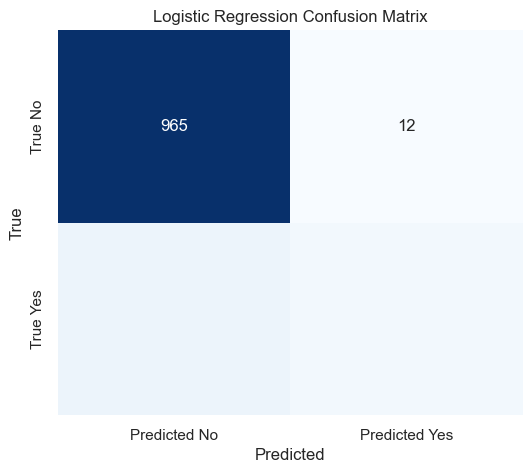

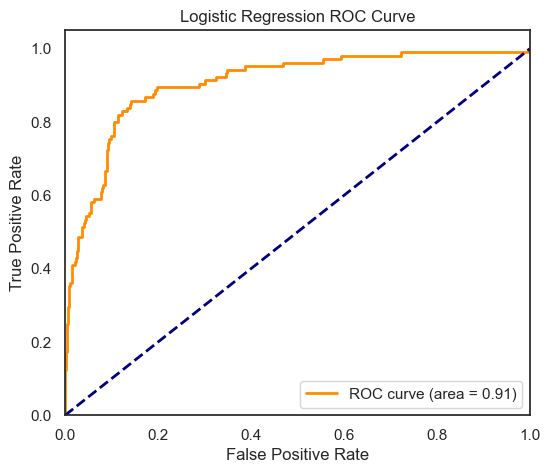

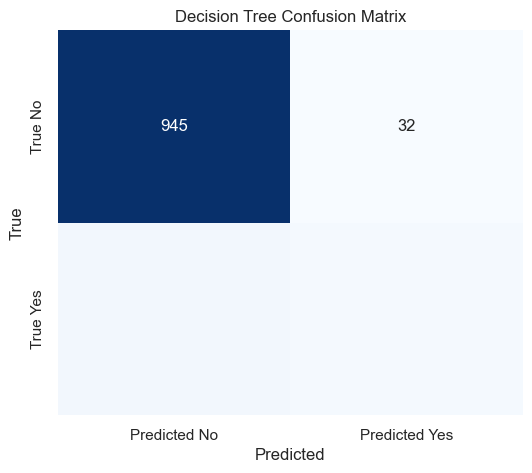

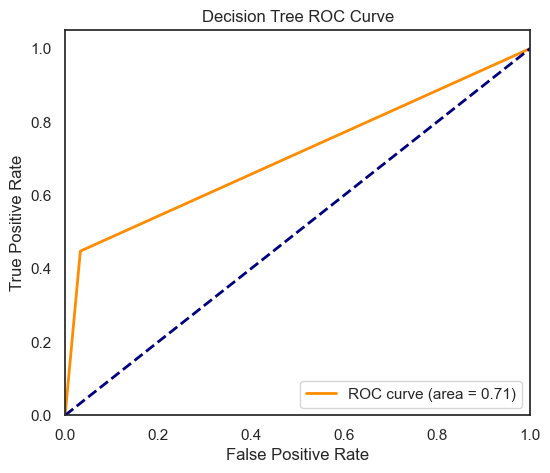

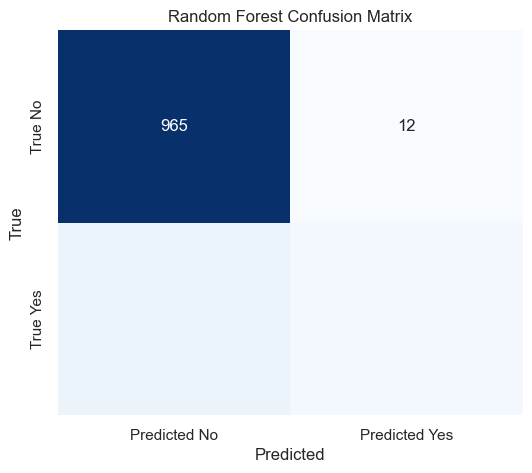

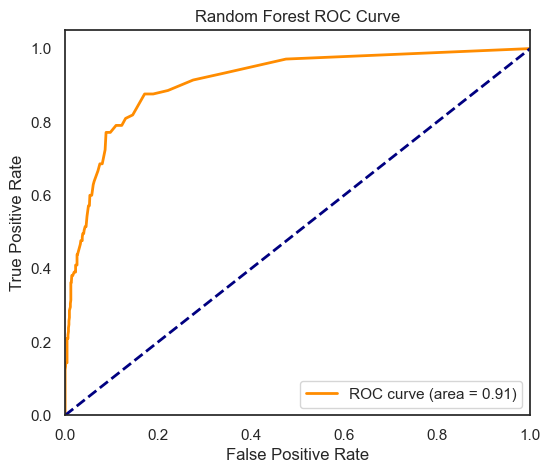

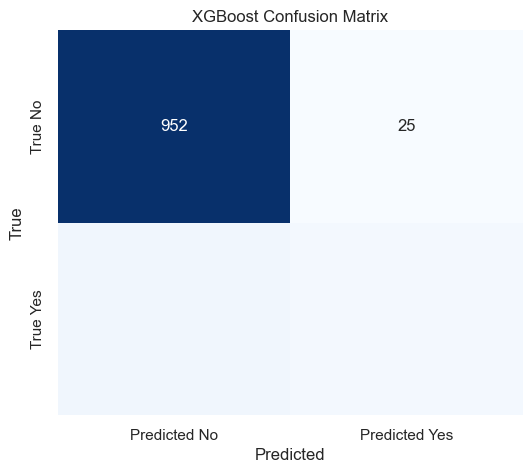

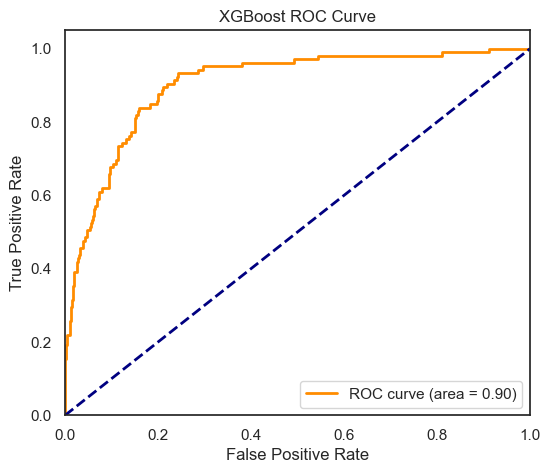

[LightGBM] [Info] Number of positive: 401, number of negative: 3927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8693
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092652 -> initscore=-2.281670
[LightGBM] [Info] Start training from score -2.281670


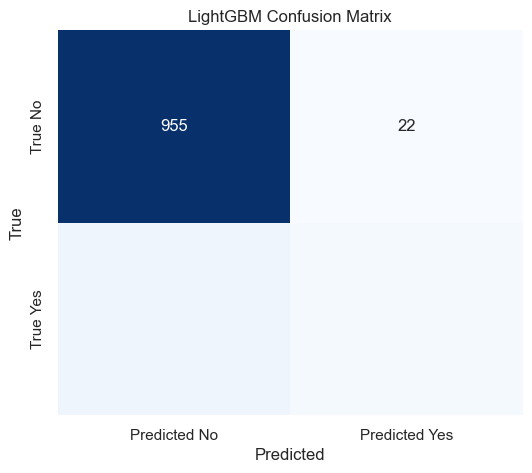

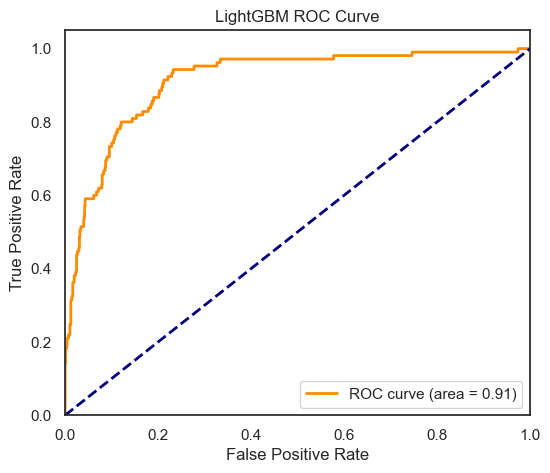

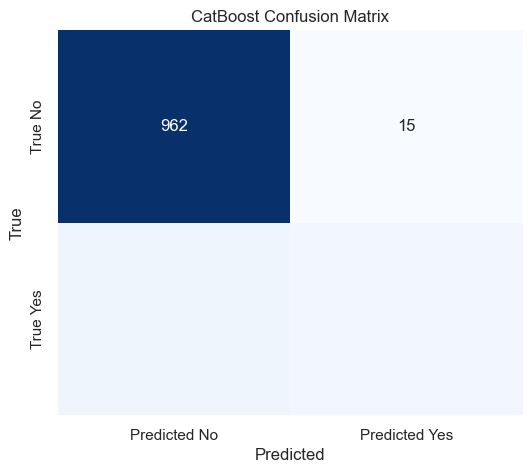

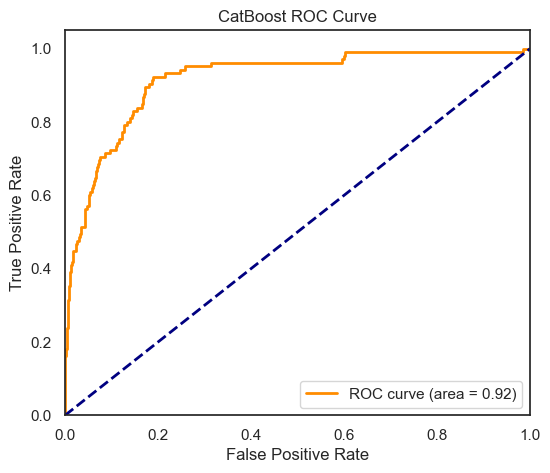

In [218]:
# compare multiple classification models (Logistic Regression, Decision Tree, Random Forest, XGBoost, LightGBM, and CatBoost) 
# using both confusion matrices and ROC-AUC curves.
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted No', 'Predicted Yes'], 
                yticklabels=['True No', 'True Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Function to plot ROC-AUC curve
def plot_roc_auc(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to evaluate a single model
def evaluate_single_model(model, model_name, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
    
    # Plot confusion matrix and ROC curve
    plot_confusion_matrix(y_test, y_pred, model_name)
    plot_roc_auc(y_test, y_pred_prob, model_name)

# df_final_IOB and 'PotentialFraud'
X = df_final_IOB.drop(columns=['PotentialFraud'])
y = df_final_IOB['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numeric columns
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['number']).columns

# Step 1: Handle missing values (if any)
# Create a ColumnTransformer to apply different preprocessing steps to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by replacing with the mean
            ('scaler', StandardScaler())  # Scale numeric features
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing with 'missing'
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
        ]), categorical_features)
    ])

# Step 2: Apply preprocessing to your data (both train and test)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Define models
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    xgb.XGBClassifier(eval_metric='logloss', random_state=42),  # Removed use_label_encoder
    lgb.LGBMClassifier(random_state=42),
    CatBoostClassifier(iterations=100, depth=10, random_state=42, verbose=0)
]

# Define model names for labeling
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]

# Evaluate each model separately
for model, model_name in zip(models, model_names):
    evaluate_single_model(model, model_name, X_train_processed, X_test_processed, y_train, y_test)

[LightGBM] [Info] Number of positive: 401, number of negative: 3927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8693
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092652 -> initscore=-2.281670
[LightGBM] [Info] Start training from score -2.281670


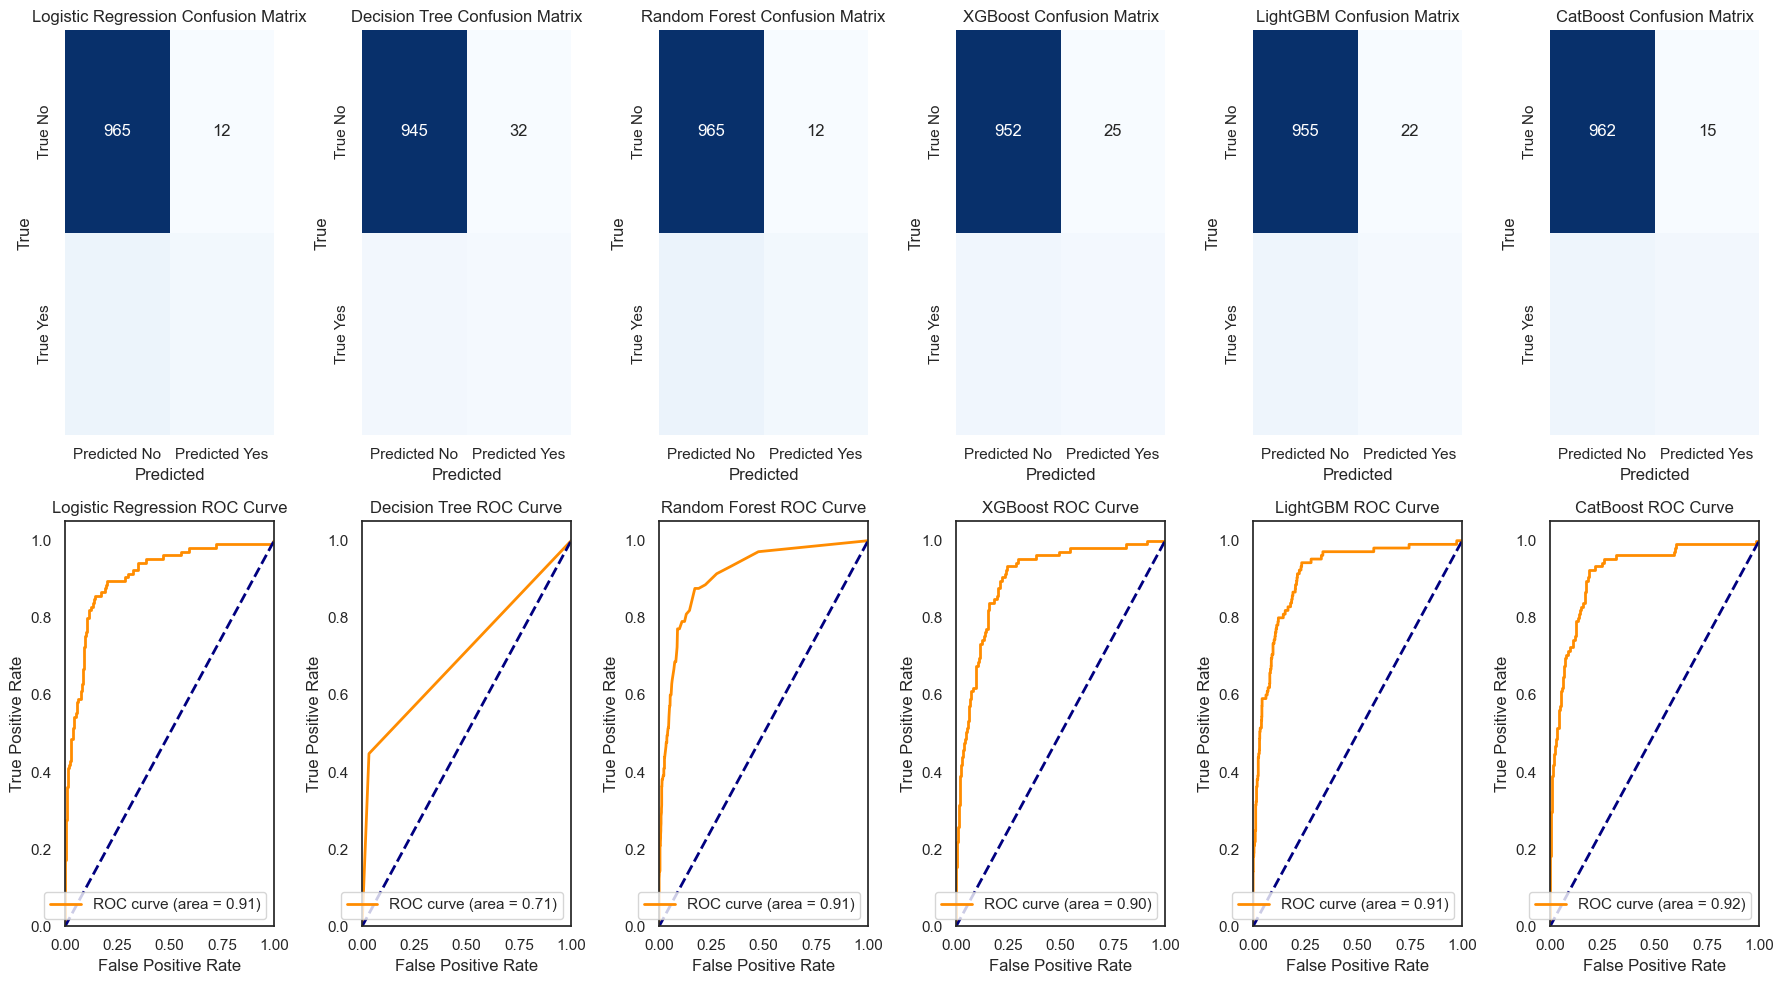

In [216]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, 
                xticklabels=['Predicted No', 'Predicted Yes'], 
                yticklabels=['True No', 'True Yes'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model_name} Confusion Matrix')

# Function to plot ROC-AUC curve
def plot_roc_auc(y_true, y_pred_prob, ax, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} ROC Curve')
    ax.legend(loc="lower right")

# Function to compare multiple models
def compare_models(models, model_names, X_train, X_test, y_train, y_test):
    fig, axes = plt.subplots(2, len(models), figsize=(18, 10))
    
    for i, model in enumerate(models):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
        
        # Confusion Matrix
        plot_confusion_matrix(y_test, y_pred, axes[0, i], model_names[i])
        
        # ROC Curve
        plot_roc_auc(y_test, y_pred_prob, axes[1, i], model_names[i])
    
    plt.tight_layout()
    plt.show()

# df_final_IOB and  'PotentialFraud'
X = df_final_IOB.drop(columns=['PotentialFraud'])
y = df_final_IOB['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numeric columns
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['number']).columns

# Step 1: Handle missing values (if any)
# Create a ColumnTransformer to apply different preprocessing steps to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by replacing with the mean
            ('scaler', StandardScaler())  # Scale numeric features
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing with 'missing'
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
        ]), categorical_features)
    ])

# Step 2: Apply preprocessing to your data (both train and test)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Define models
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    xgb.XGBClassifier(eval_metric='logloss', random_state=42),  # Removed use_label_encoder
    lgb.LGBMClassifier(random_state=42),
    CatBoostClassifier(iterations=100, depth=10, random_state=42, verbose=0)
]

# Define model names for labeling
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]

# Compare models
compare_models(models, model_names, X_train_processed, X_test_processed, y_train, y_test)

In [219]:
# Function to compute metrics for each model
def compute_metrics(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict the results
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, roc_auc, precision, recall, f1

# Define models and model names
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    xgb.XGBClassifier(eval_metric='logloss', random_state=42),  # Removed use_label_encoder
    lgb.LGBMClassifier(random_state=42),
    CatBoostClassifier(iterations=100, depth=10, random_state=42, verbose=0)
]

model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]

# Initialize an empty list to store the metrics for each model
metrics = []

# Compute metrics for each model
for model, model_name in zip(models, model_names):
    model_metrics = compute_metrics(model, X_train_processed, X_test_processed, y_train, y_test)
    metrics.append([model_name] + list(model_metrics))

# Create a DataFrame to display the metrics as a table
metrics_df = pd.DataFrame(metrics, columns=['Model', 'Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score'])

# Display the comparison table
print(metrics_df)

[LightGBM] [Info] Number of positive: 401, number of negative: 3927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8693
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092652 -> initscore=-2.281670
[LightGBM] [Info] Start training from score -2.281670
                 Model  Accuracy   ROC-AUC  Precision    Recall  F1-Score
0  Logistic Regression  0.926987  0.906848   0.760000  0.361905  0.490323
1        Decision Tree  0.916821  0.707433   0.594937  0.447619  0.510870
2        Random Forest  0.926063  0.910601   0.755102  0.352381  0.480519
3              XGBoost  0.920518  0.903075   0.637681  0.419048  0.505747
4             LightGBM  0.919593  0.912867   0.645161  0.380952  0.479042
5             CatBoost  0.928835  0.917210   0.741379  0.409524  0